## This script is used to run through the 174 subvolumes that Jaco created and determine how well the cell detector performs

In [20]:
import sys
from brainlit.utils.session import NeuroglancerSession
import numpy as np
import os
from cloudvolume import CloudVolume
import matplotlib.pyplot as plt
import boto3
from cloudvolume import Bbox

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Change the following path to your local installation of brainlit
sys.path.append("/Users/johnduva/Desktop/Git/NeuroData/brainlit") 

## Load Prerna's Model

In [2]:
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        m = nn.Sigmoid()
        x = m(x)
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()
m1.load_state_dict(torch.load('crossvalidation4.pt', map_location = torch.device('cpu') ))
m1 = m1.double()

## Loop through 174 subvols and download the data

In [6]:
volumes_dir = "jaco_volumes/"
s3 = boto3.resource('s3')
bucket = s3.Bucket("open-neurodata")

mip = 2
dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
neuroglancer = NeuroglancerSession(mip=mip, url=dir, url_segments=dir_segments)
res = neuroglancer.cv_segments.scales[neuroglancer.mip]["resolution"]

bboxs = []; volumes=[]
somas_prefix = "brainlit/brain1_somas/"
for vol_object in bucket.objects.filter(Prefix=somas_prefix):
    vol_key = vol_object.key
    vol_id  = os.path.basename(vol_object.key)
    if vol_id != "":
        vol_filepath = os.path.join(volumes_dir, f"{vol_id}.npy")
        bucket.download_file(vol_key, vol_filepath)
        coords = np.load(vol_filepath, allow_pickle=True)
        volume_coords = np.array(os.path.basename(vol_object.key).split("_")).astype(float)
        volume_vox_min = np.round(np.divide(volume_coords[:3], res)).astype(int)
        volume_vox_max = np.round(np.divide(volume_coords[3:], res)).astype(int)
        bbox = Bbox(volume_vox_min, volume_vox_max)
        volume = neuroglancer.pull_bounds_img(bbox)

        bboxs.append(bbox)
        volumes.append(volume)

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]


## For each of 174 volumes...
- Create list of 12x12x12 subvolumes (which moves in each dimension by `stride` pixels at a time)
- Convert to proper shape
- Normalize the data
- Test model on each window in the list
- Order the list of windows by score (keeping track of subvol's coordinates in the brain)
- Only keep the higheset scoring window when there are multiple windows with high scores that are very close to each other
- Plot and manually investigate outputs to assess reliability 

Note: `print()` statements were used for debugging but have been commented out to improve speed.

Subvolume #0 in Jaco data:


<Figure size 432x288 with 0 Axes>

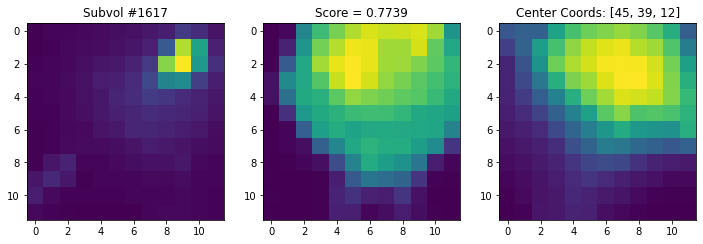

Subvolume #1 in Jaco data:


<Figure size 432x288 with 0 Axes>

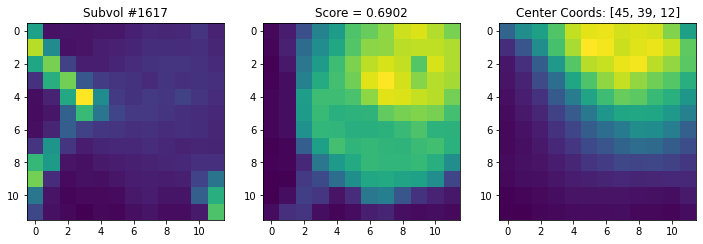

Subvolume #2 in Jaco data:


<Figure size 432x288 with 0 Axes>

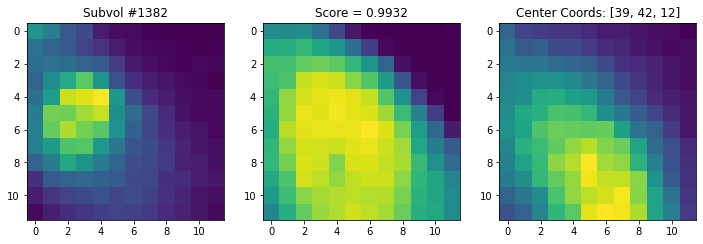

<Figure size 432x288 with 0 Axes>

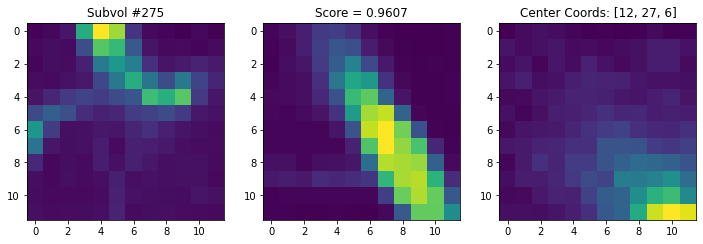

Subvolume #3 in Jaco data:


<Figure size 432x288 with 0 Axes>

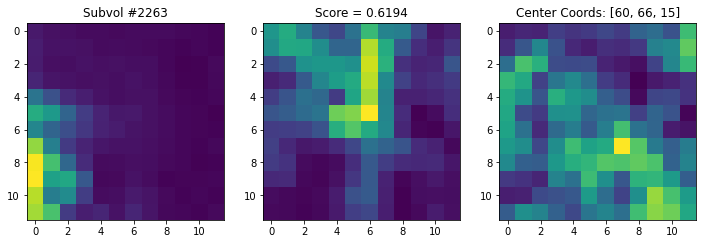

<Figure size 432x288 with 0 Axes>

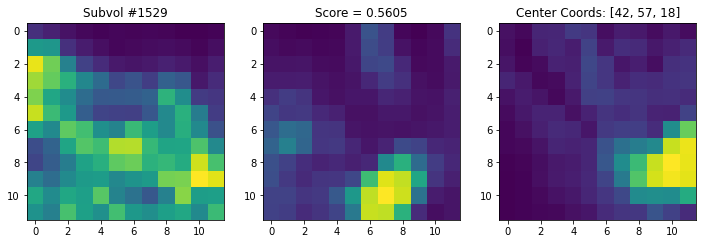

Subvolume #4 in Jaco data:
Subvolume #5 in Jaco data:


<Figure size 432x288 with 0 Axes>

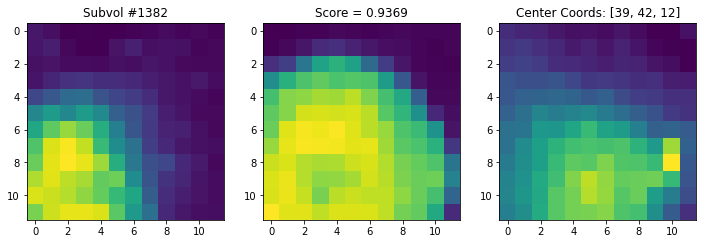

Subvolume #6 in Jaco data:


<Figure size 432x288 with 0 Axes>

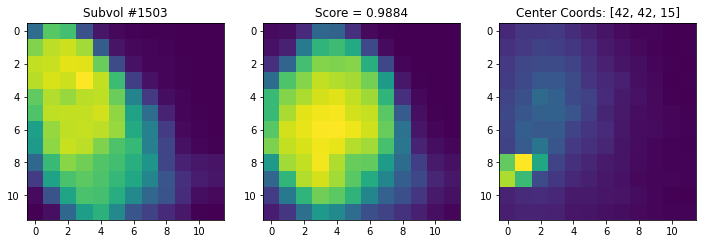

Subvolume #7 in Jaco data:


<Figure size 432x288 with 0 Axes>

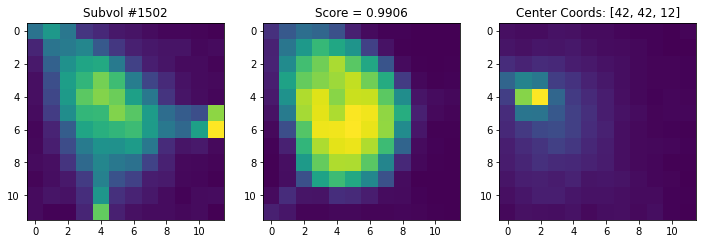

Subvolume #8 in Jaco data:


<Figure size 432x288 with 0 Axes>

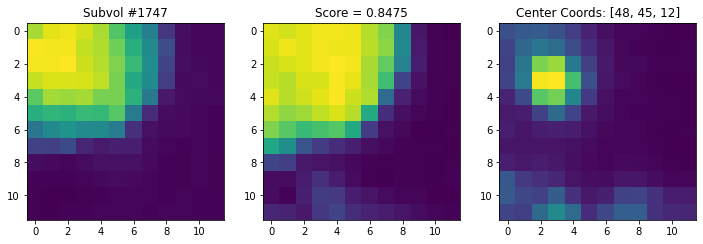

Subvolume #9 in Jaco data:
Subvolume #10 in Jaco data:


<Figure size 432x288 with 0 Axes>

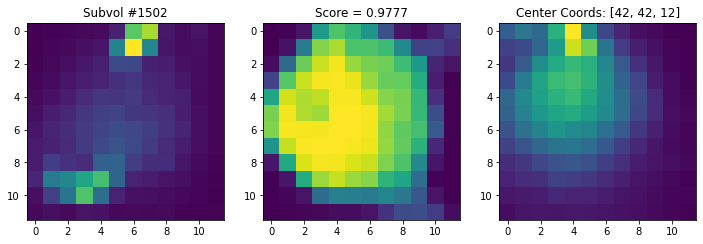

Subvolume #11 in Jaco data:


<Figure size 432x288 with 0 Axes>

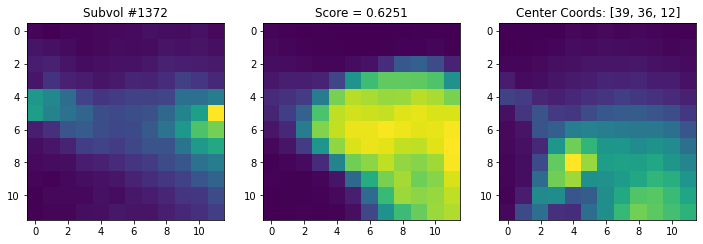

Subvolume #12 in Jaco data:


<Figure size 432x288 with 0 Axes>

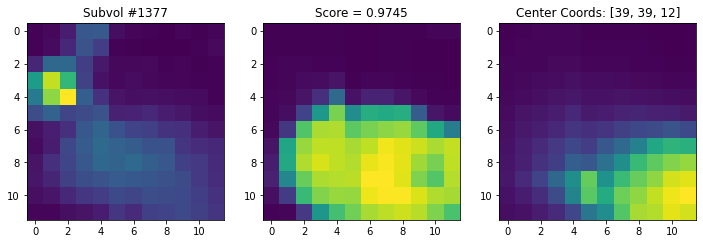

Subvolume #13 in Jaco data:


<Figure size 432x288 with 0 Axes>

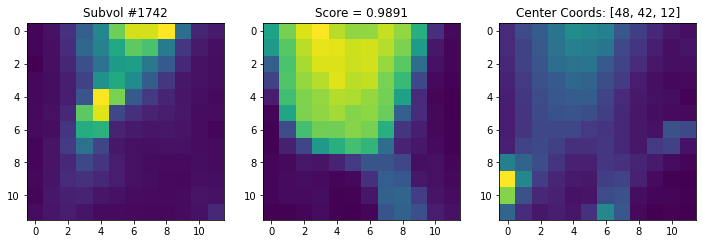

Subvolume #14 in Jaco data:


<Figure size 432x288 with 0 Axes>

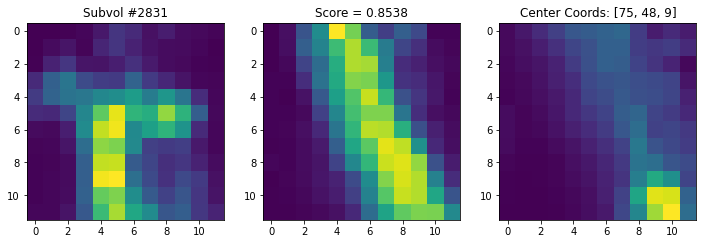

<Figure size 432x288 with 0 Axes>

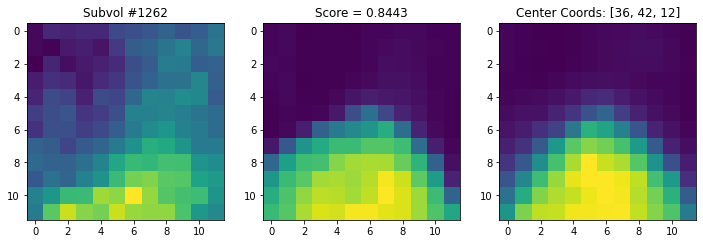

Subvolume #15 in Jaco data:


<Figure size 432x288 with 0 Axes>

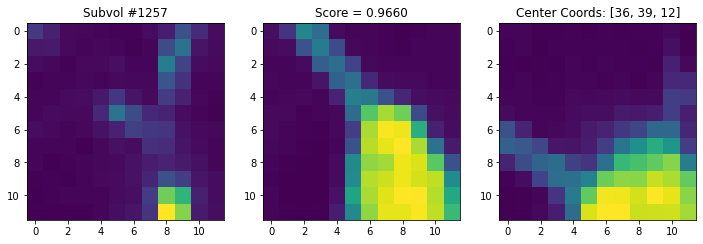

Subvolume #16 in Jaco data:
Subvolume #17 in Jaco data:


<Figure size 432x288 with 0 Axes>

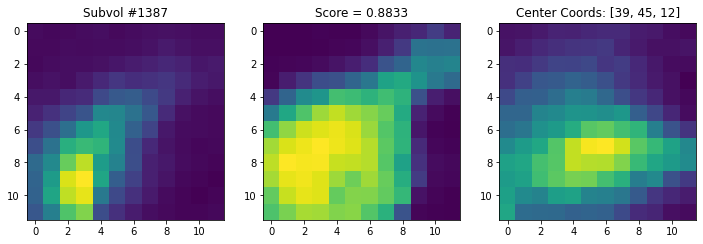

Subvolume #18 in Jaco data:
Subvolume #19 in Jaco data:


<Figure size 432x288 with 0 Axes>

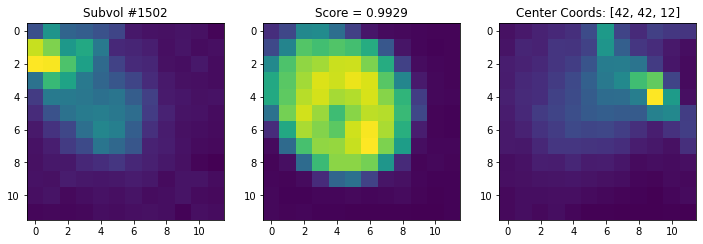

Subvolume #20 in Jaco data:
Subvolume #21 in Jaco data:


<Figure size 432x288 with 0 Axes>

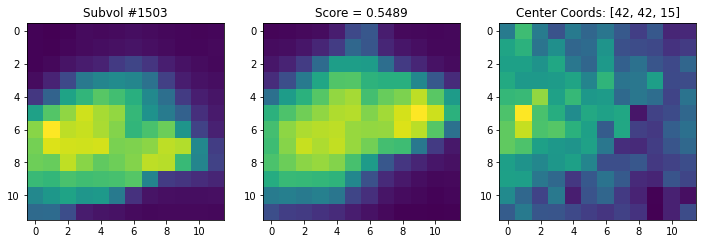

Subvolume #22 in Jaco data:
Subvolume #23 in Jaco data:


<Figure size 432x288 with 0 Axes>

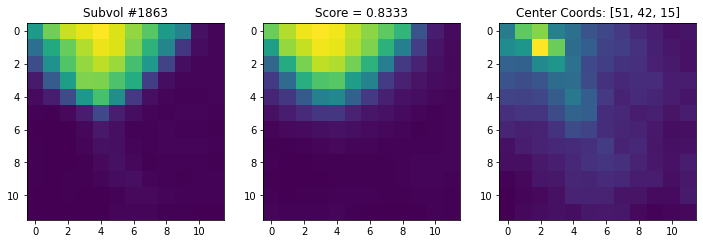

<Figure size 432x288 with 0 Axes>

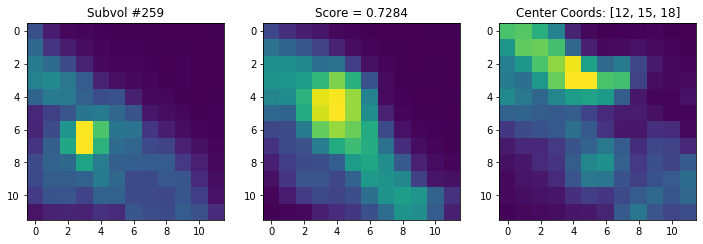

Subvolume #24 in Jaco data:


<Figure size 432x288 with 0 Axes>

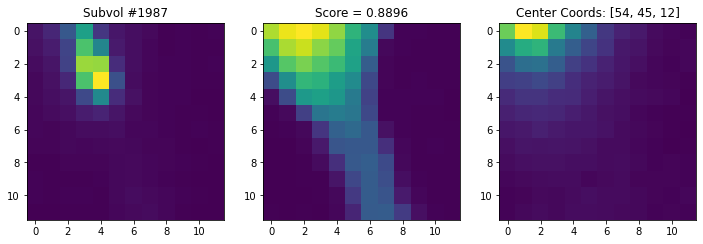

<Figure size 432x288 with 0 Axes>

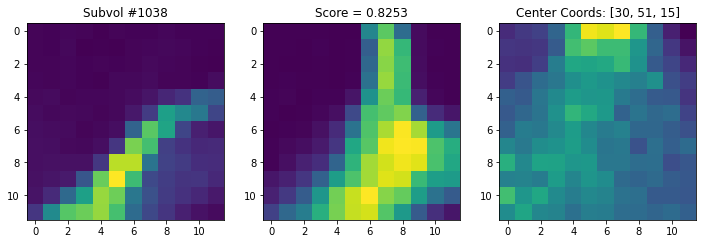

Subvolume #25 in Jaco data:


<Figure size 432x288 with 0 Axes>

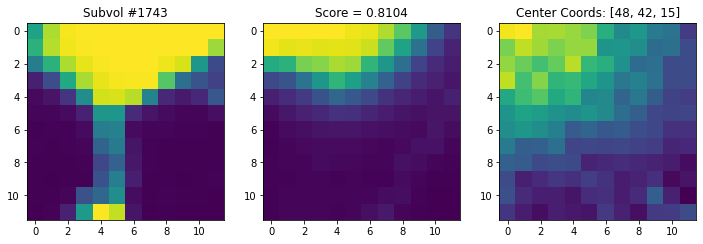

<Figure size 432x288 with 0 Axes>

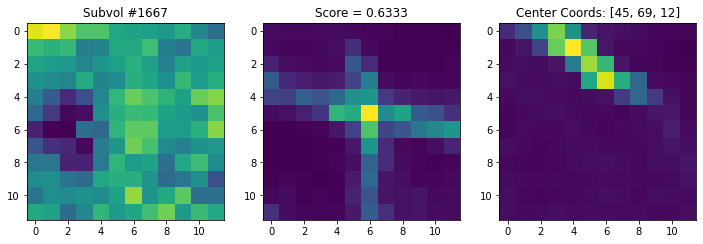

Subvolume #26 in Jaco data:


<Figure size 432x288 with 0 Axes>

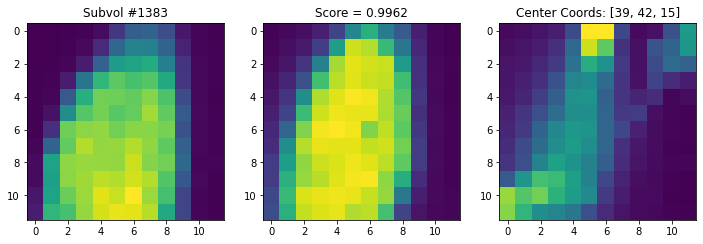

Subvolume #27 in Jaco data:


<Figure size 432x288 with 0 Axes>

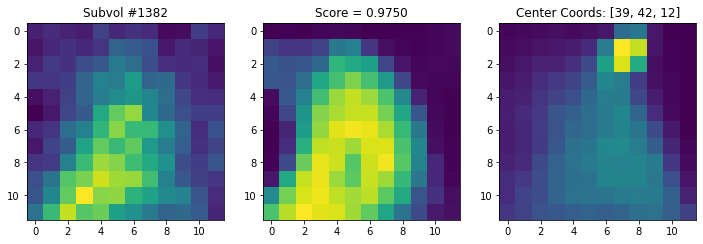

<Figure size 432x288 with 0 Axes>

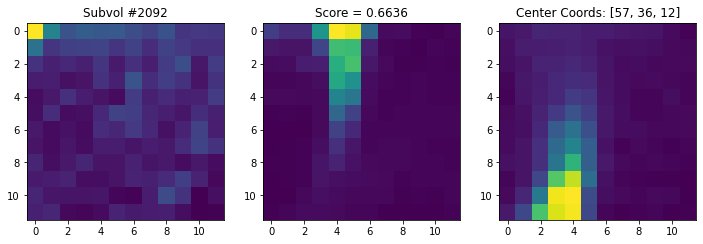

Subvolume #28 in Jaco data:


<Figure size 432x288 with 0 Axes>

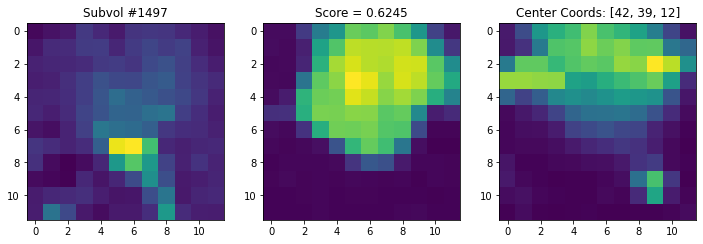

Subvolume #29 in Jaco data:


<Figure size 432x288 with 0 Axes>

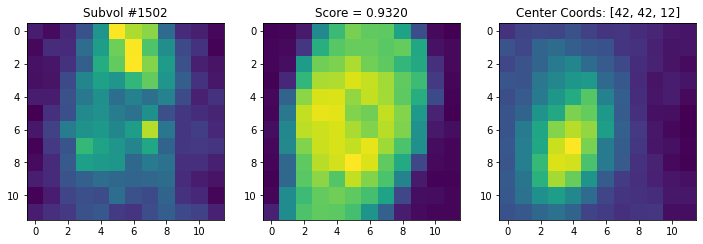

Subvolume #30 in Jaco data:


<Figure size 432x288 with 0 Axes>

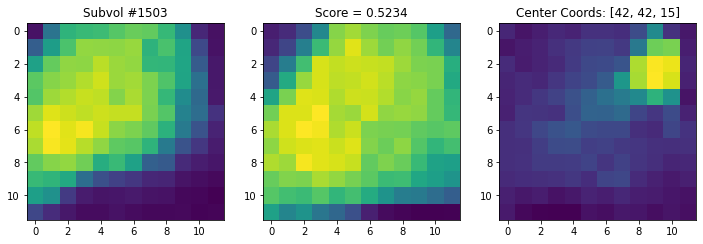

Subvolume #31 in Jaco data:


<Figure size 432x288 with 0 Axes>

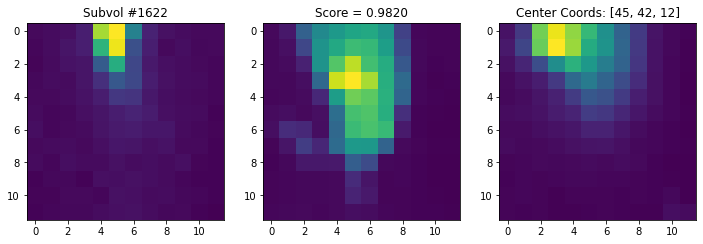

Subvolume #32 in Jaco data:


<Figure size 432x288 with 0 Axes>

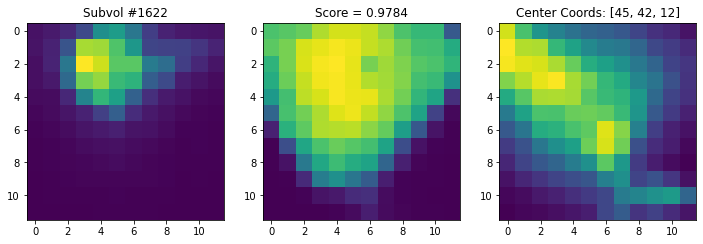

Subvolume #33 in Jaco data:


<Figure size 432x288 with 0 Axes>

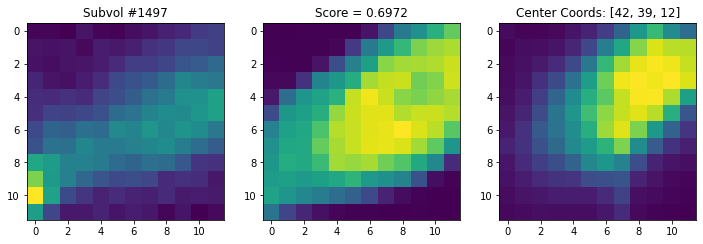

Subvolume #34 in Jaco data:


<Figure size 432x288 with 0 Axes>

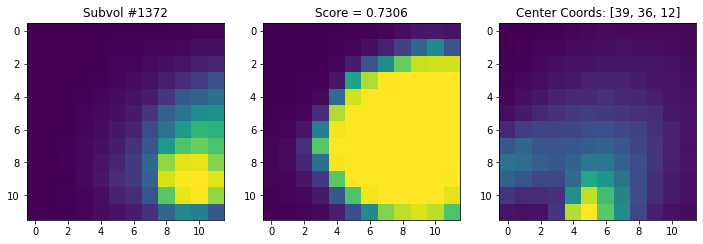

Subvolume #35 in Jaco data:


<Figure size 432x288 with 0 Axes>

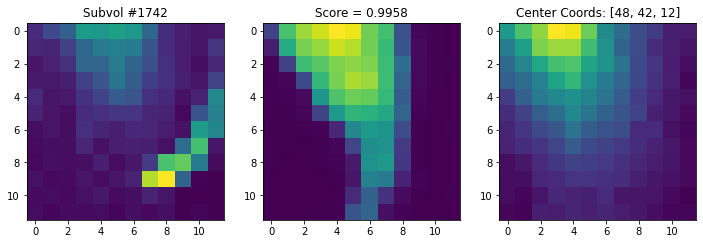

<Figure size 432x288 with 0 Axes>

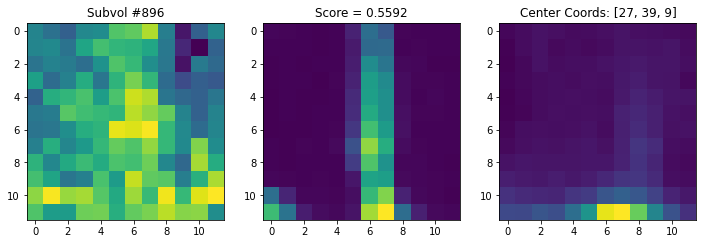

Subvolume #36 in Jaco data:


<Figure size 432x288 with 0 Axes>

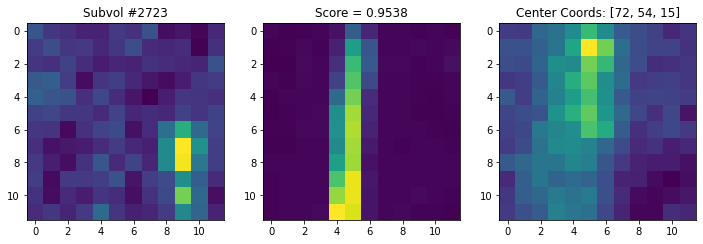

<Figure size 432x288 with 0 Axes>

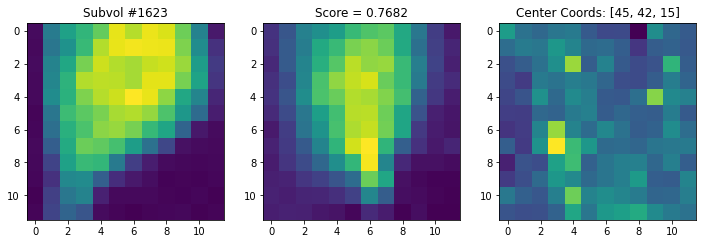

<Figure size 432x288 with 0 Axes>

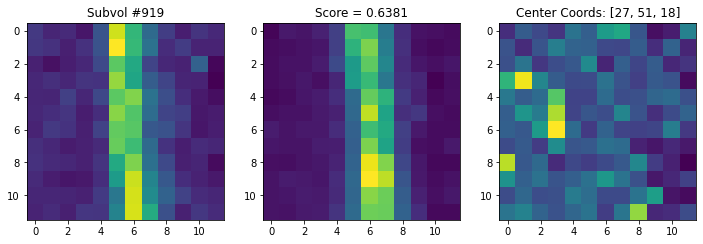

Subvolume #37 in Jaco data:


<Figure size 432x288 with 0 Axes>

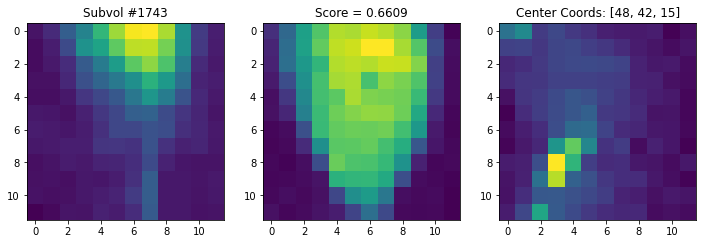

Subvolume #38 in Jaco data:


<Figure size 432x288 with 0 Axes>

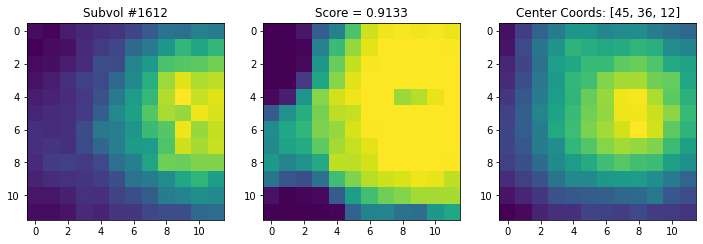

<Figure size 432x288 with 0 Axes>

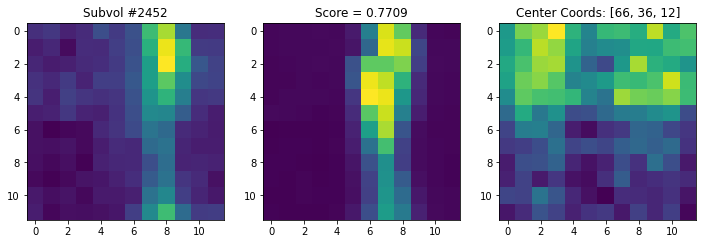

<Figure size 432x288 with 0 Axes>

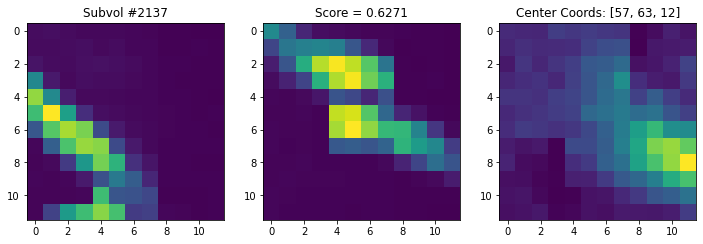

Subvolume #39 in Jaco data:


<Figure size 432x288 with 0 Axes>

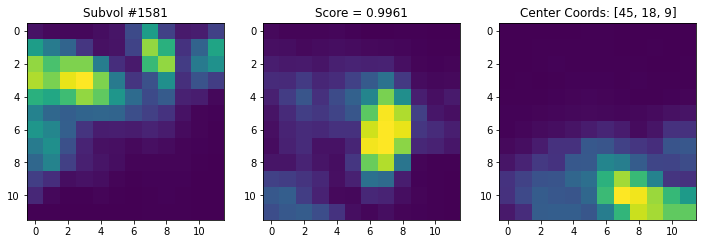

<Figure size 432x288 with 0 Axes>

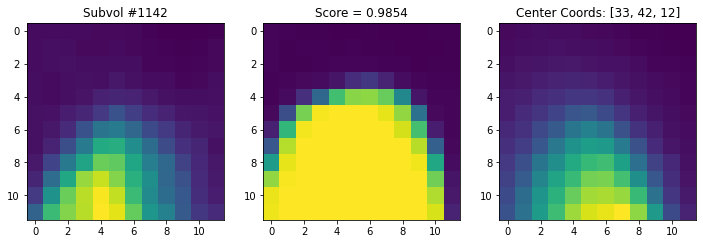

Subvolume #40 in Jaco data:


<Figure size 432x288 with 0 Axes>

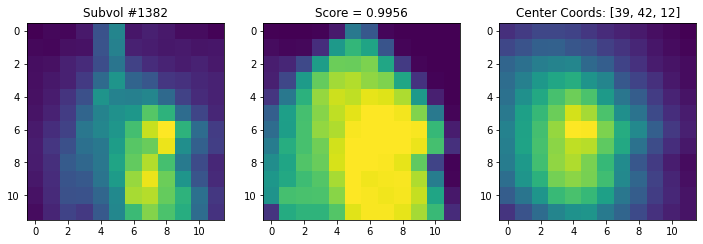

Subvolume #41 in Jaco data:


<Figure size 432x288 with 0 Axes>

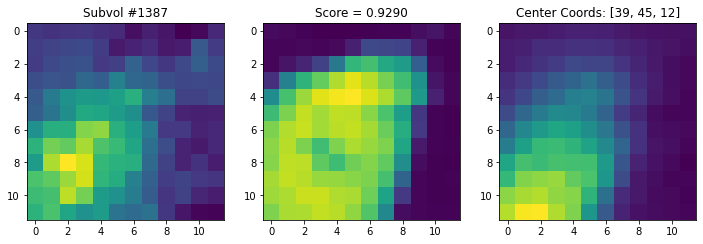

<Figure size 432x288 with 0 Axes>

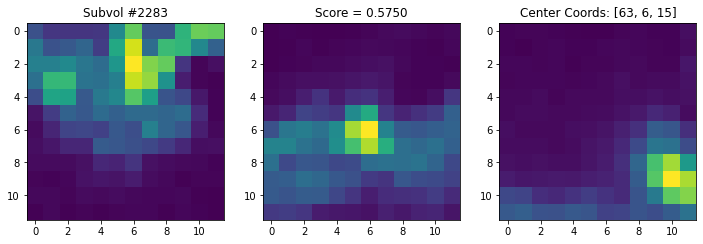

Subvolume #42 in Jaco data:


<Figure size 432x288 with 0 Axes>

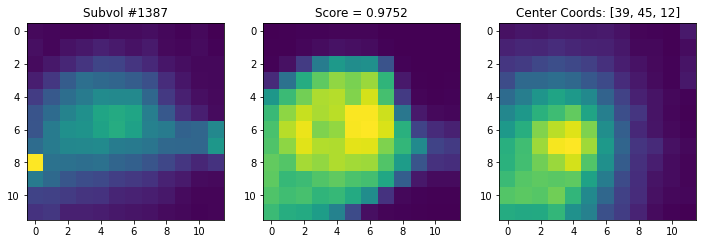

Subvolume #43 in Jaco data:


<Figure size 432x288 with 0 Axes>

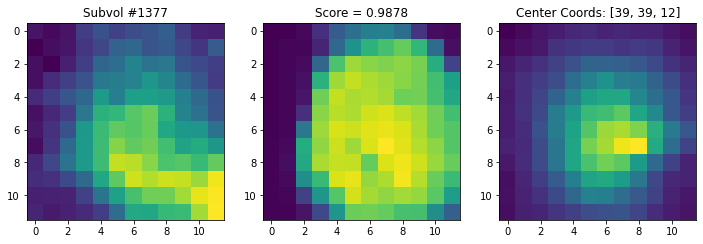

<Figure size 432x288 with 0 Axes>

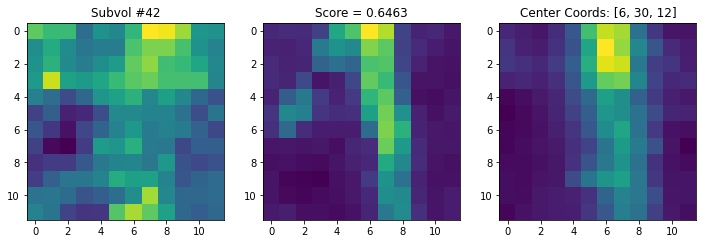

Subvolume #44 in Jaco data:


<Figure size 432x288 with 0 Axes>

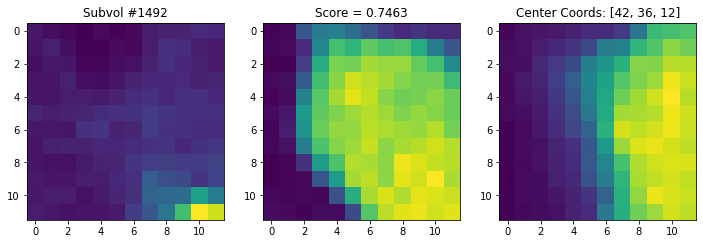

Subvolume #45 in Jaco data:


<Figure size 432x288 with 0 Axes>

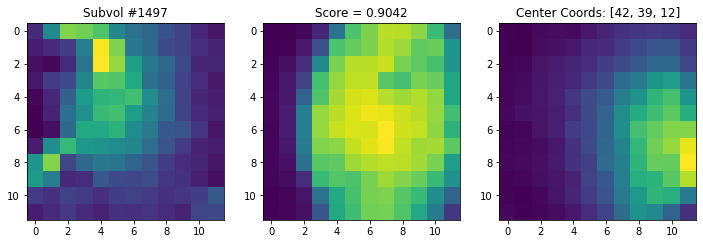

<Figure size 432x288 with 0 Axes>

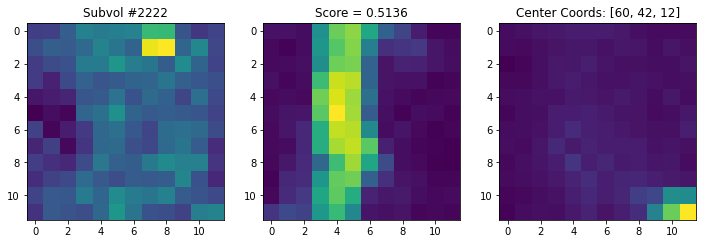

Subvolume #46 in Jaco data:


<Figure size 432x288 with 0 Axes>

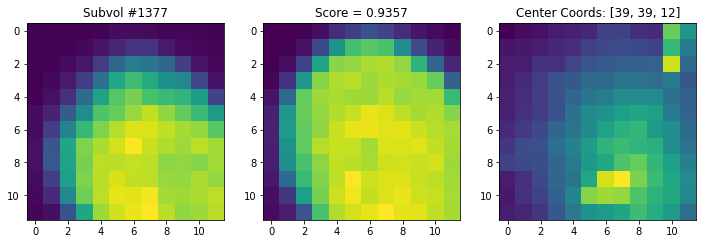

Subvolume #47 in Jaco data:


<Figure size 432x288 with 0 Axes>

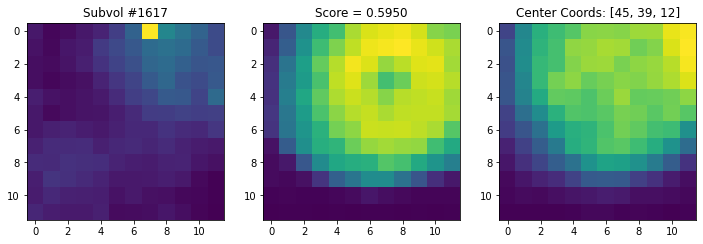

Subvolume #48 in Jaco data:


<Figure size 432x288 with 0 Axes>

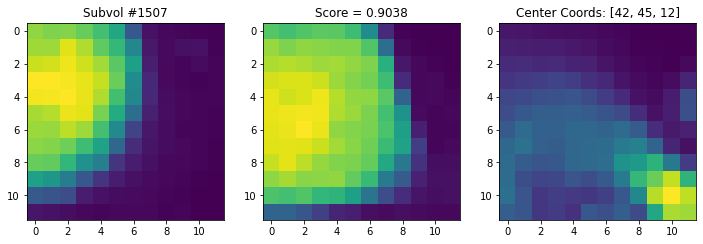

<Figure size 432x288 with 0 Axes>

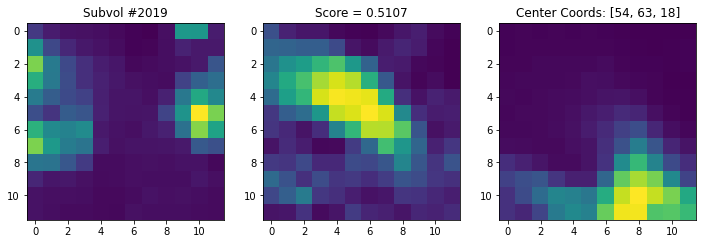

Subvolume #49 in Jaco data:


<Figure size 432x288 with 0 Axes>

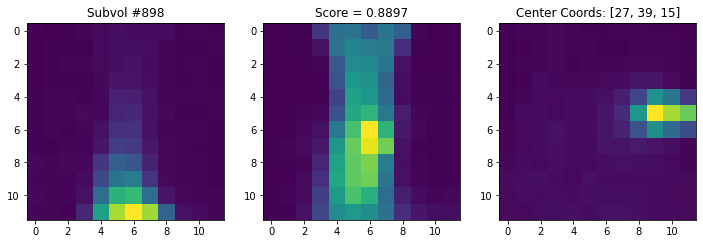

Subvolume #50 in Jaco data:


<Figure size 432x288 with 0 Axes>

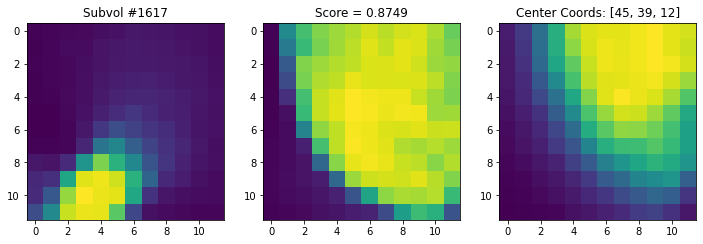

Subvolume #51 in Jaco data:


<Figure size 432x288 with 0 Axes>

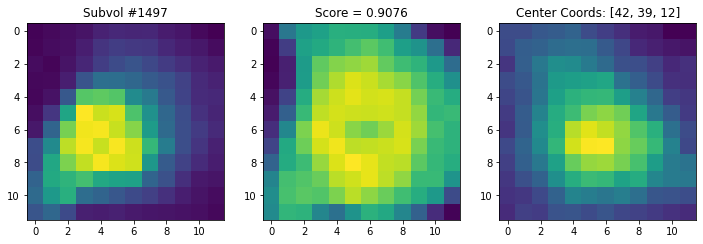

Subvolume #52 in Jaco data:


<Figure size 432x288 with 0 Axes>

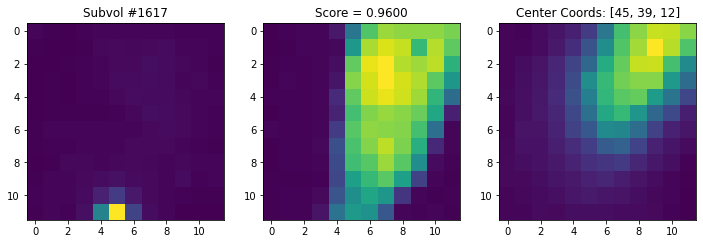

Subvolume #53 in Jaco data:


<Figure size 432x288 with 0 Axes>

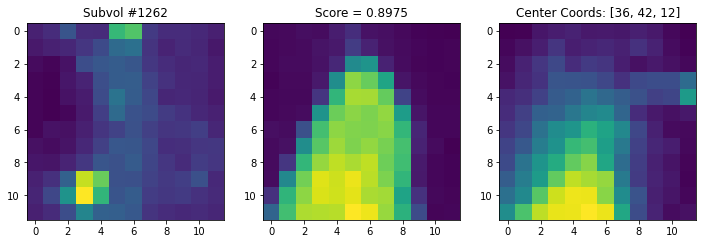

Subvolume #54 in Jaco data:


<Figure size 432x288 with 0 Axes>

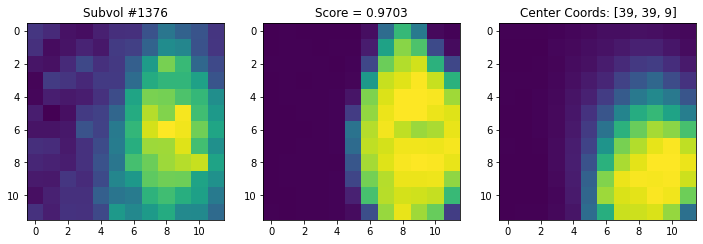

Subvolume #55 in Jaco data:


<Figure size 432x288 with 0 Axes>

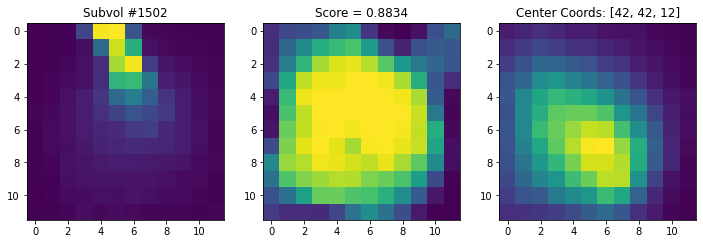

<Figure size 432x288 with 0 Axes>

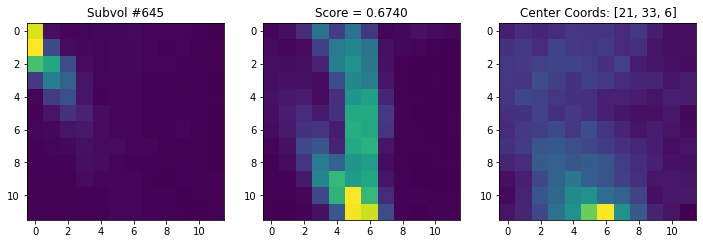

Subvolume #56 in Jaco data:


<Figure size 432x288 with 0 Axes>

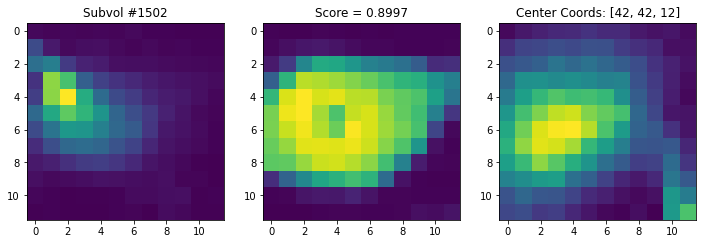

<Figure size 432x288 with 0 Axes>

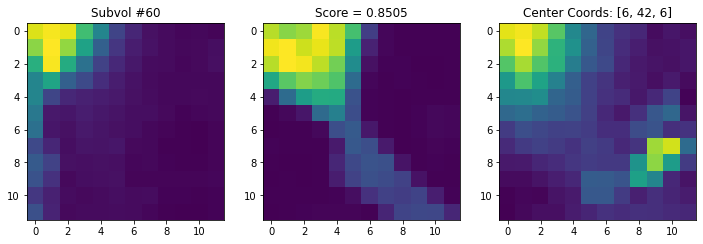

Subvolume #57 in Jaco data:


<Figure size 432x288 with 0 Axes>

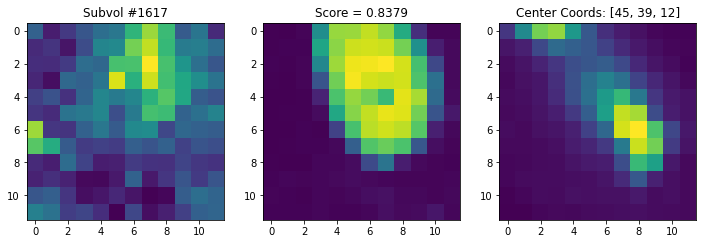

<Figure size 432x288 with 0 Axes>

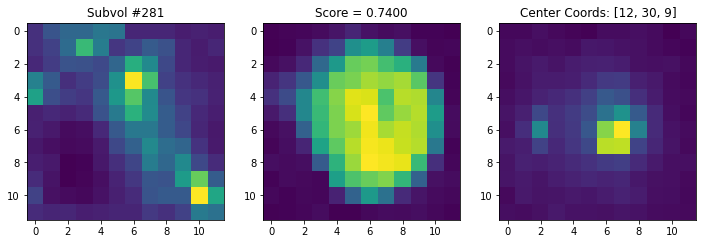

Subvolume #58 in Jaco data:


<Figure size 432x288 with 0 Axes>

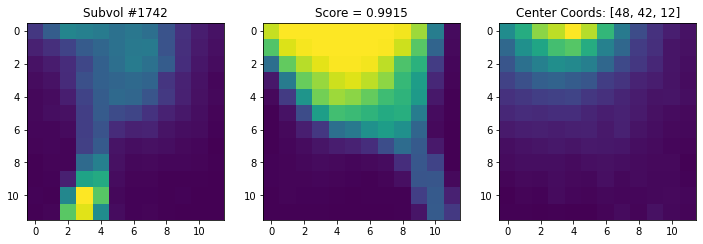

<Figure size 432x288 with 0 Axes>

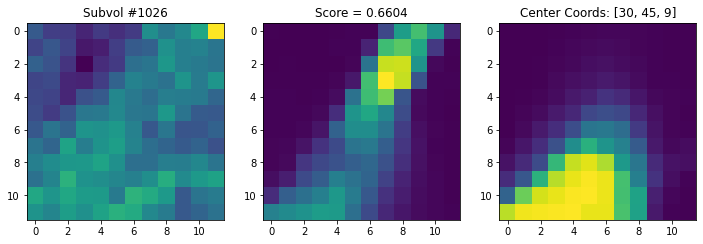

Subvolume #59 in Jaco data:


<Figure size 432x288 with 0 Axes>

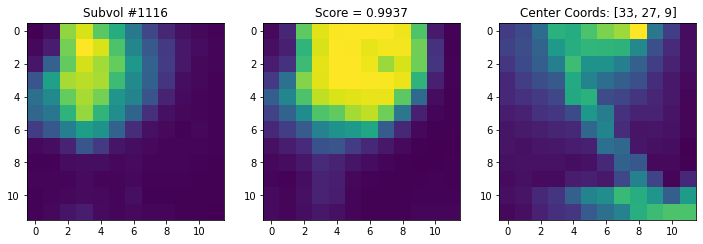

<Figure size 432x288 with 0 Axes>

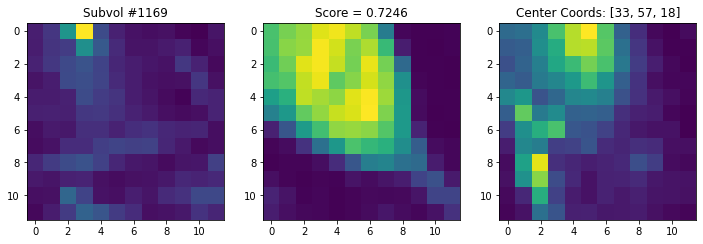

Subvolume #60 in Jaco data:


<Figure size 432x288 with 0 Axes>

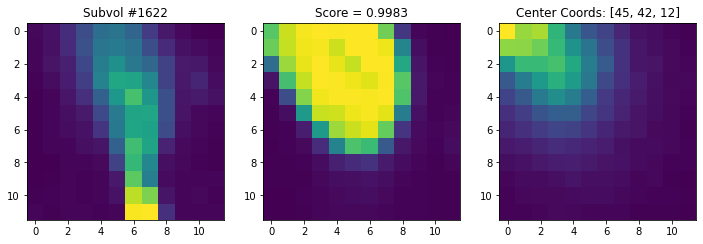

<Figure size 432x288 with 0 Axes>

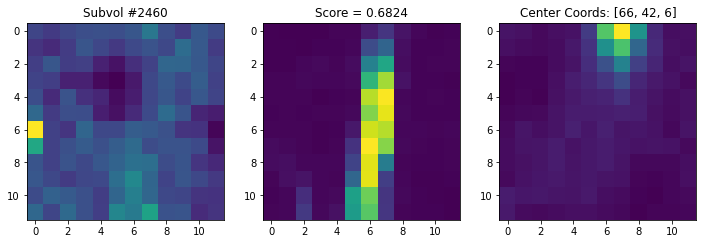

<Figure size 432x288 with 0 Axes>

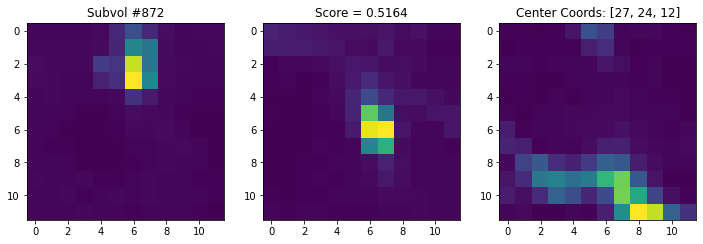

Subvolume #61 in Jaco data:


<Figure size 432x288 with 0 Axes>

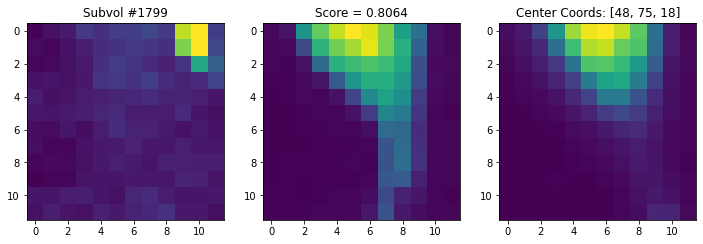

<Figure size 432x288 with 0 Axes>

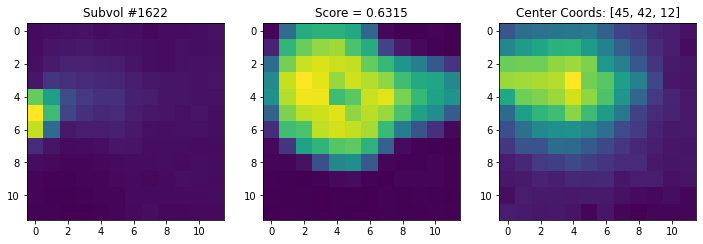

Subvolume #62 in Jaco data:
Subvolume #63 in Jaco data:


<Figure size 432x288 with 0 Axes>

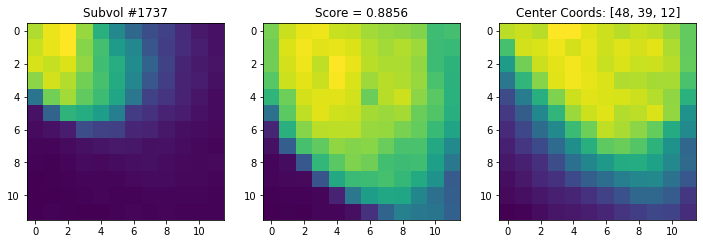

Subvolume #64 in Jaco data:


<Figure size 432x288 with 0 Axes>

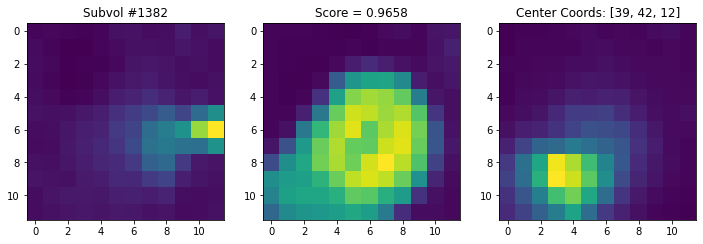

Subvolume #65 in Jaco data:


<Figure size 432x288 with 0 Axes>

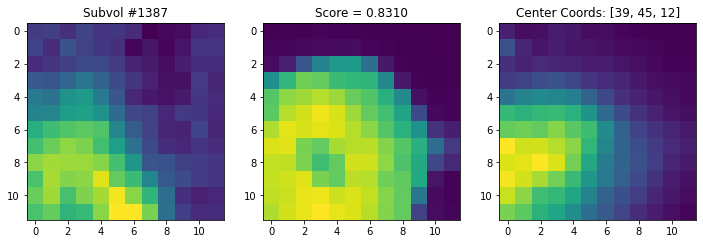

Subvolume #66 in Jaco data:


<Figure size 432x288 with 0 Axes>

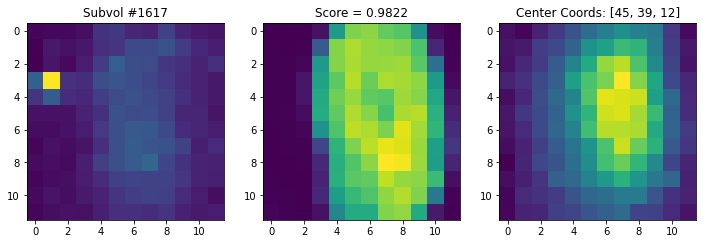

Subvolume #67 in Jaco data:
Subvolume #68 in Jaco data:
Subvolume #69 in Jaco data:


<Figure size 432x288 with 0 Axes>

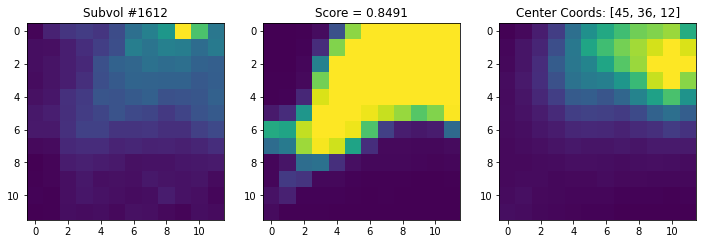

Subvolume #70 in Jaco data:


<Figure size 432x288 with 0 Axes>

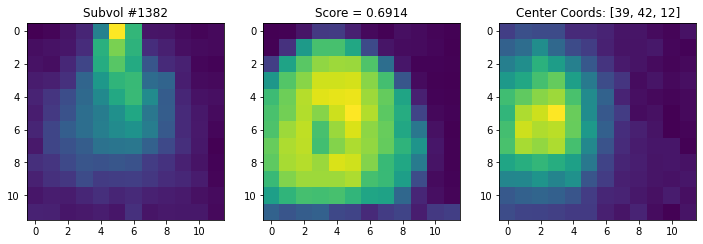

Subvolume #71 in Jaco data:


<Figure size 432x288 with 0 Axes>

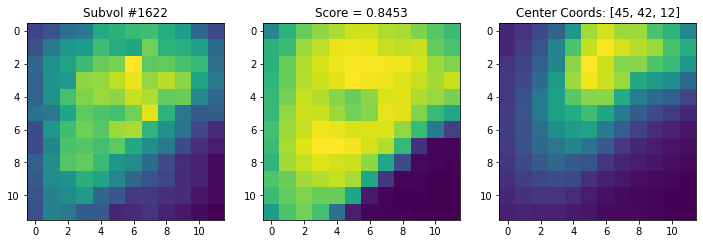

Subvolume #72 in Jaco data:
Subvolume #73 in Jaco data:


<Figure size 432x288 with 0 Axes>

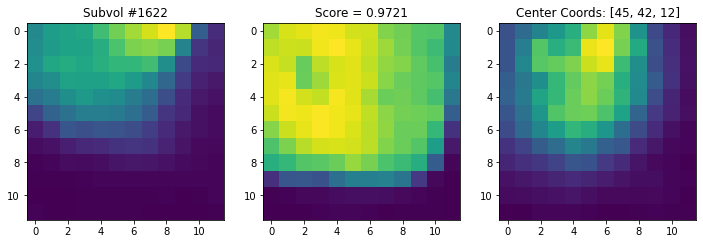

Subvolume #74 in Jaco data:


<Figure size 432x288 with 0 Axes>

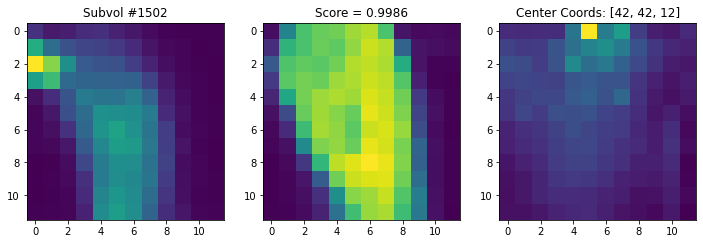

<Figure size 432x288 with 0 Axes>

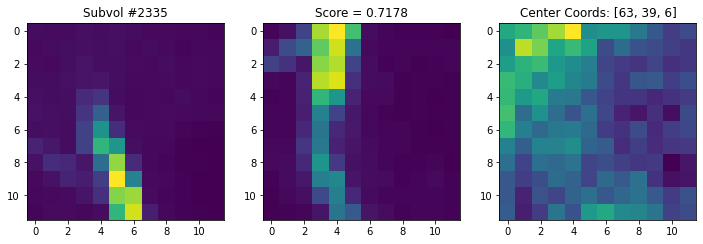

Subvolume #75 in Jaco data:


<Figure size 432x288 with 0 Axes>

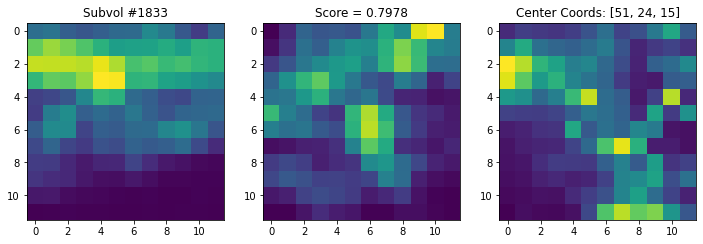

<Figure size 432x288 with 0 Axes>

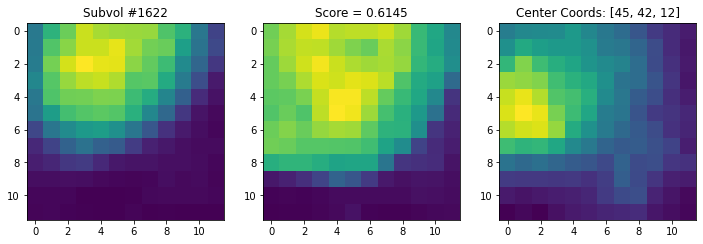

Subvolume #76 in Jaco data:


<Figure size 432x288 with 0 Axes>

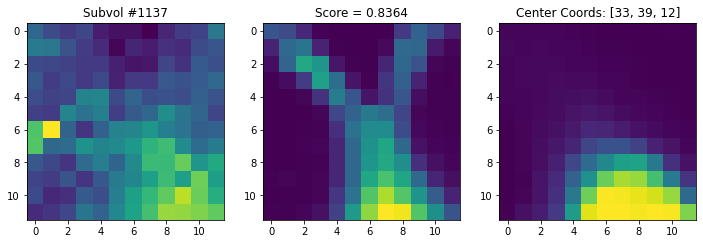

Subvolume #77 in Jaco data:


<Figure size 432x288 with 0 Axes>

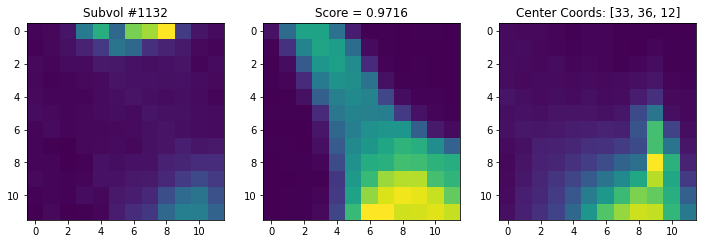

<Figure size 432x288 with 0 Axes>

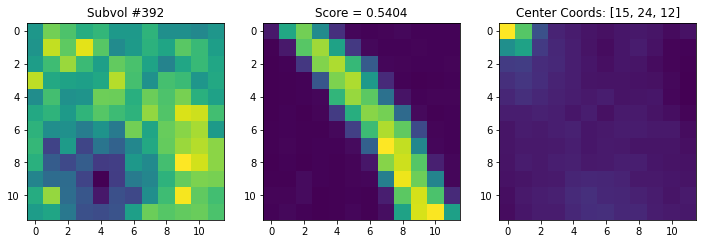

Subvolume #78 in Jaco data:


<Figure size 432x288 with 0 Axes>

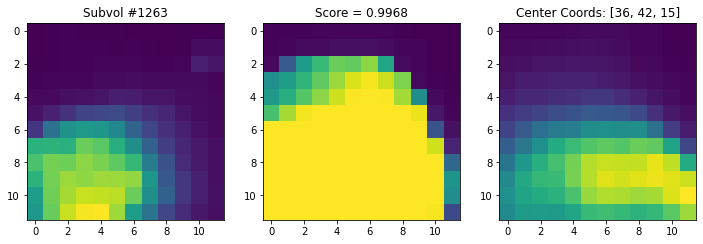

Subvolume #79 in Jaco data:


<Figure size 432x288 with 0 Axes>

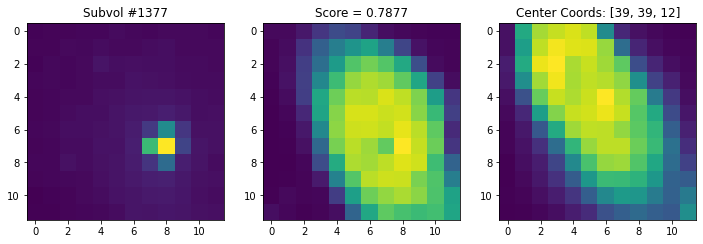

Subvolume #80 in Jaco data:


<Figure size 432x288 with 0 Axes>

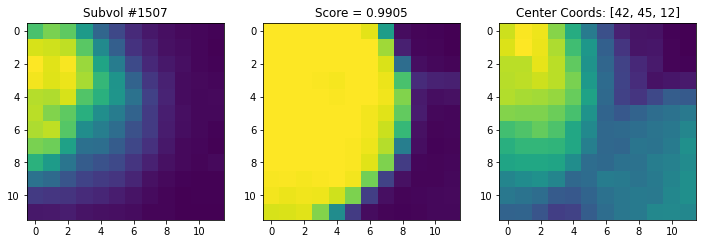

Subvolume #81 in Jaco data:


<Figure size 432x288 with 0 Axes>

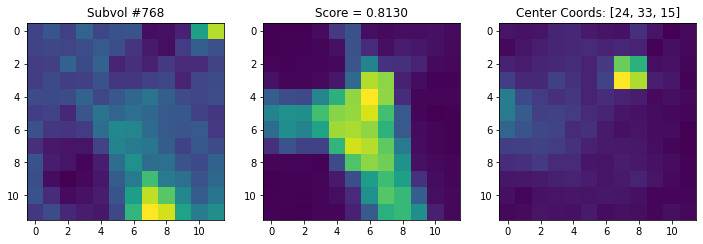

<Figure size 432x288 with 0 Axes>

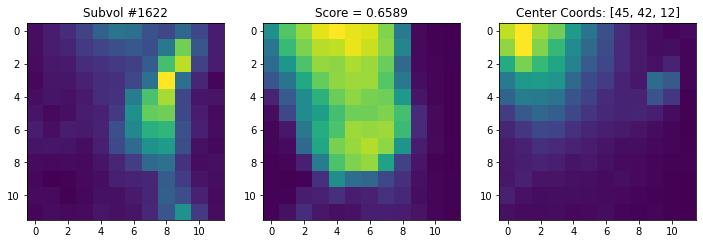

Subvolume #82 in Jaco data:
Subvolume #83 in Jaco data:


<Figure size 432x288 with 0 Axes>

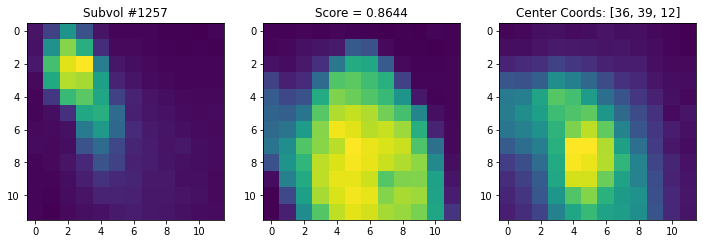

Subvolume #84 in Jaco data:


<Figure size 432x288 with 0 Axes>

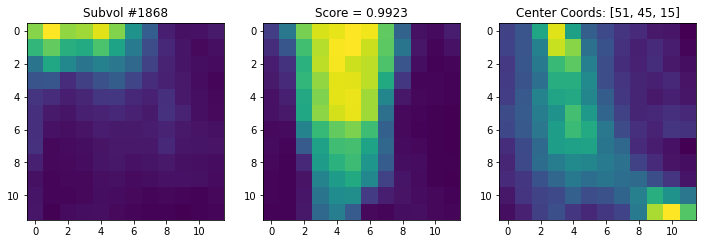

Subvolume #85 in Jaco data:
Subvolume #86 in Jaco data:


<Figure size 432x288 with 0 Axes>

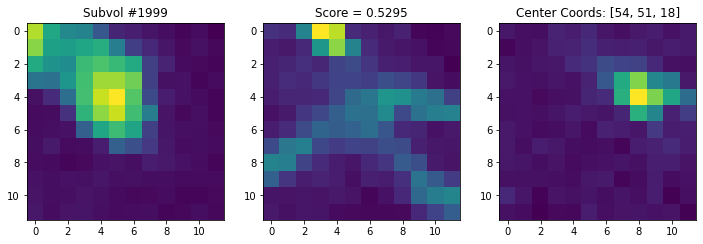

Subvolume #87 in Jaco data:


<Figure size 432x288 with 0 Axes>

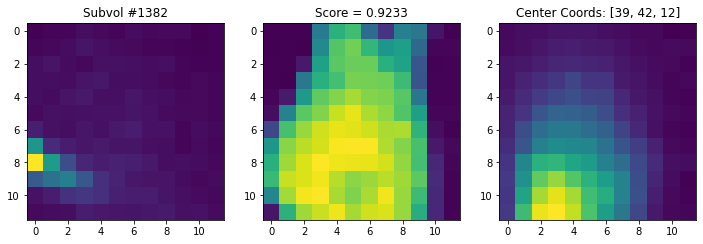

Subvolume #88 in Jaco data:


<Figure size 432x288 with 0 Axes>

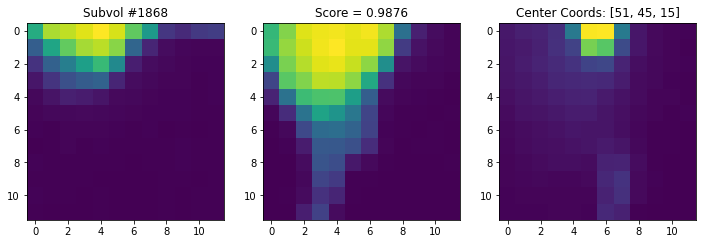

<Figure size 432x288 with 0 Axes>

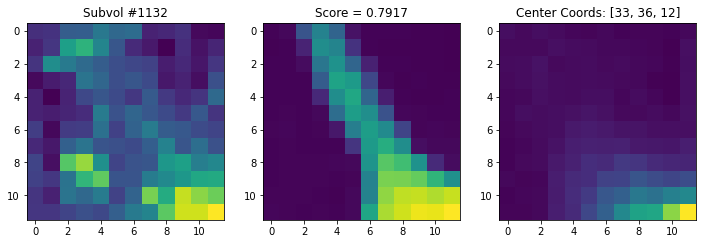

Subvolume #89 in Jaco data:


<Figure size 432x288 with 0 Axes>

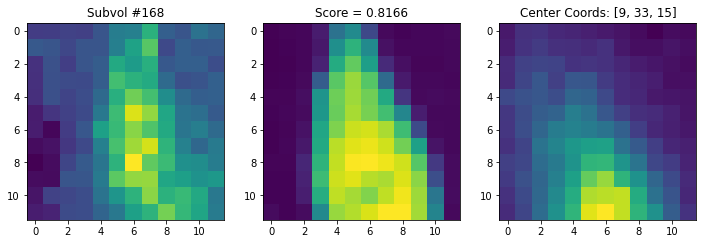

<Figure size 432x288 with 0 Axes>

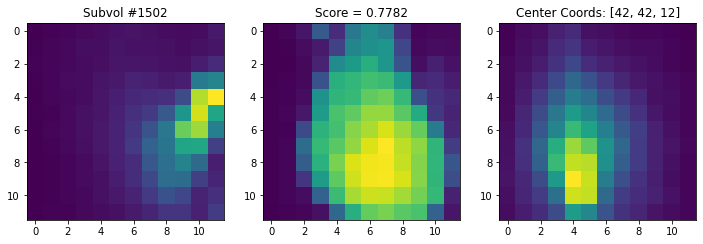

Subvolume #90 in Jaco data:


<Figure size 432x288 with 0 Axes>

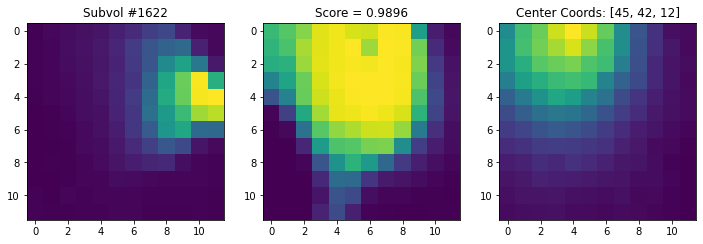

Subvolume #91 in Jaco data:


<Figure size 432x288 with 0 Axes>

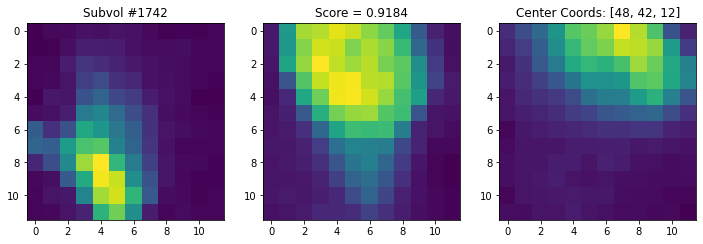

Subvolume #92 in Jaco data:


<Figure size 432x288 with 0 Axes>

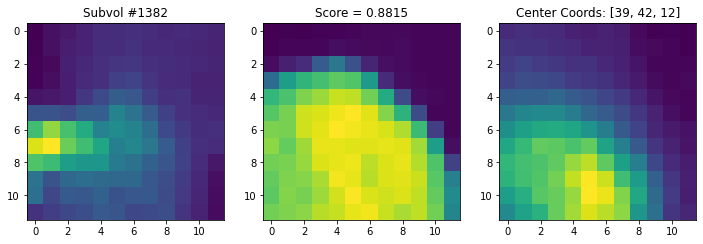

Subvolume #93 in Jaco data:


<Figure size 432x288 with 0 Axes>

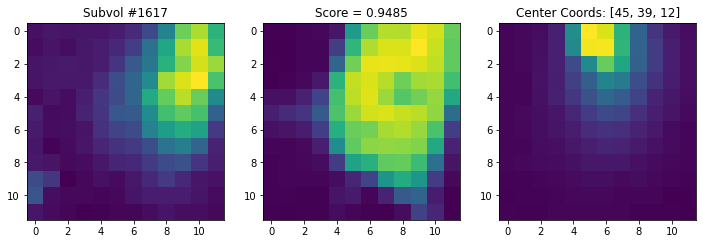

Subvolume #94 in Jaco data:


<Figure size 432x288 with 0 Axes>

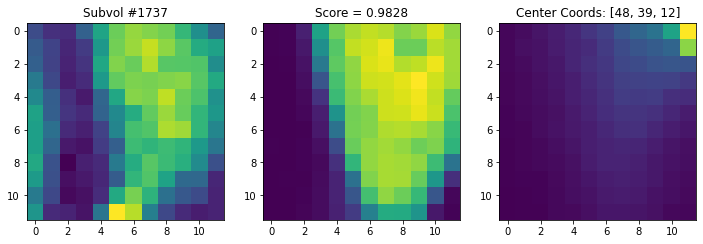

<Figure size 432x288 with 0 Axes>

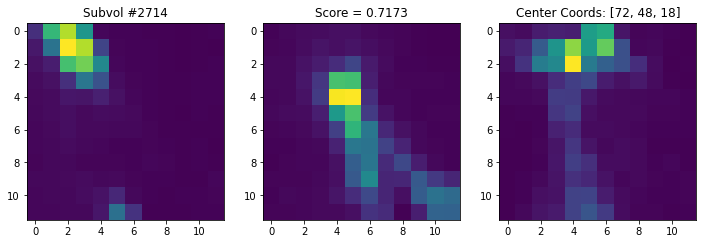

Subvolume #95 in Jaco data:


<Figure size 432x288 with 0 Axes>

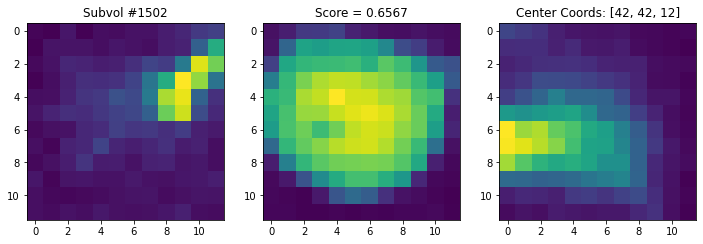

Subvolume #96 in Jaco data:


<Figure size 432x288 with 0 Axes>

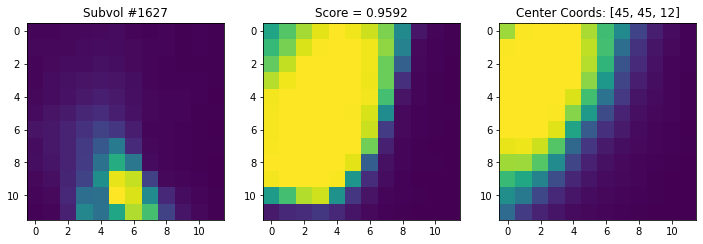

<Figure size 432x288 with 0 Axes>

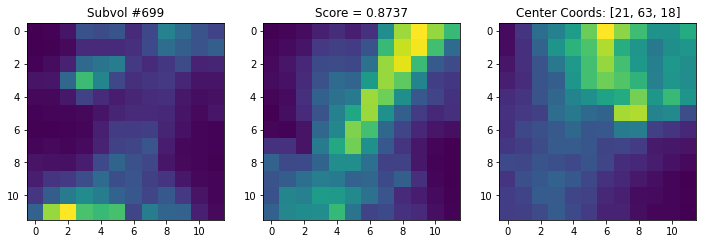

<Figure size 432x288 with 0 Axes>

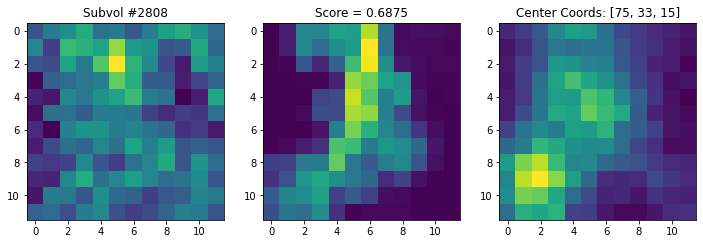

Subvolume #97 in Jaco data:


<Figure size 432x288 with 0 Axes>

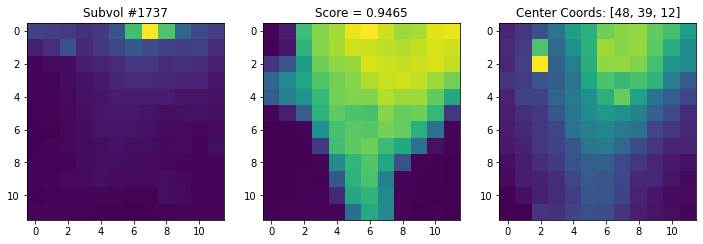

Subvolume #98 in Jaco data:


<Figure size 432x288 with 0 Axes>

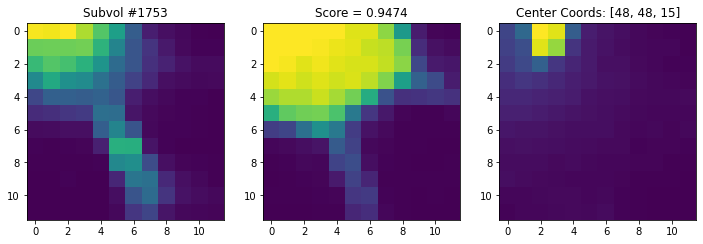

Subvolume #99 in Jaco data:


<Figure size 432x288 with 0 Axes>

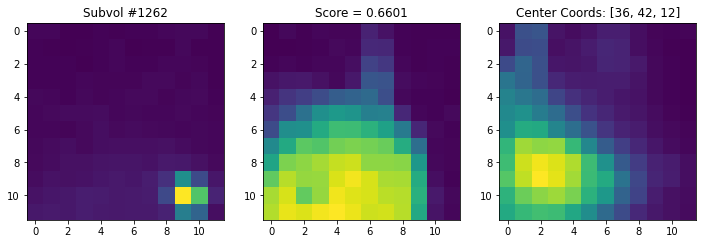

<Figure size 432x288 with 0 Axes>

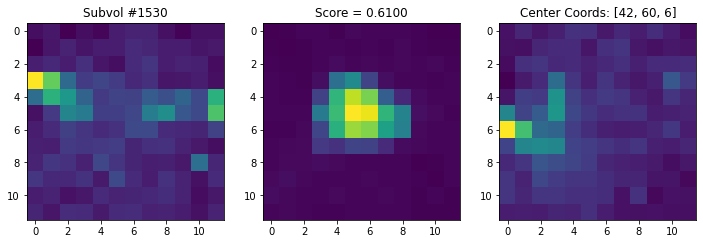

Subvolume #100 in Jaco data:


<Figure size 432x288 with 0 Axes>

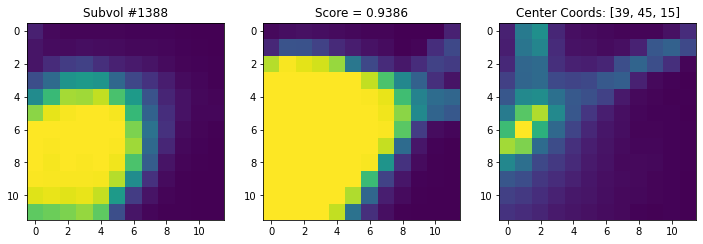

Subvolume #101 in Jaco data:


<Figure size 432x288 with 0 Axes>

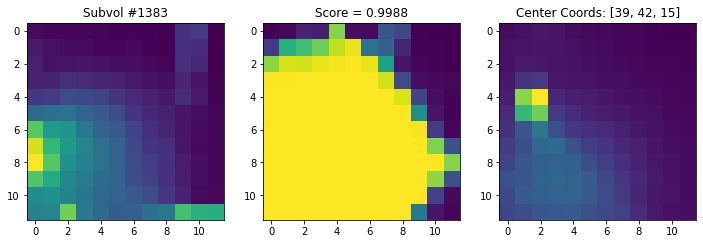

Subvolume #102 in Jaco data:
Subvolume #103 in Jaco data:
Subvolume #104 in Jaco data:


<Figure size 432x288 with 0 Axes>

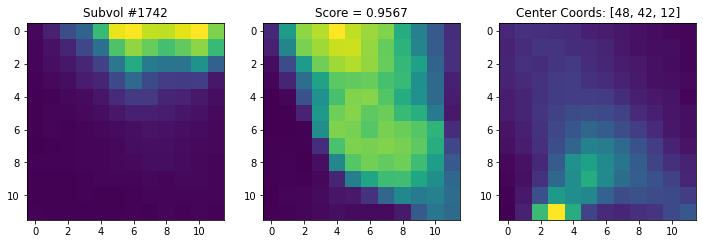

<Figure size 432x288 with 0 Axes>

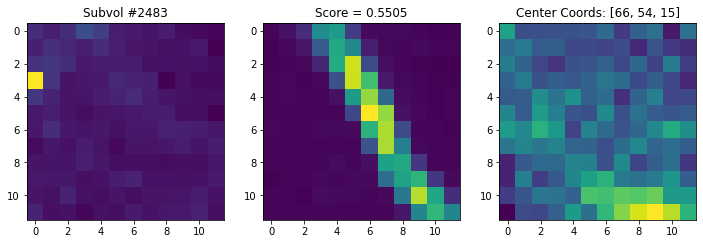

<Figure size 432x288 with 0 Axes>

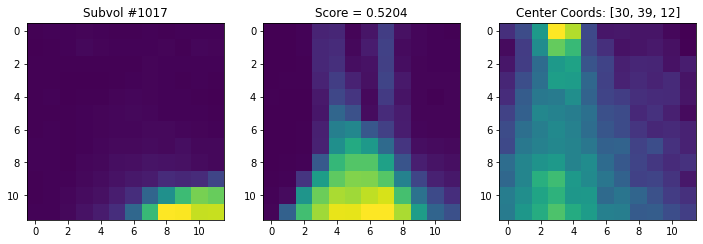

Subvolume #105 in Jaco data:
Subvolume #106 in Jaco data:


<Figure size 432x288 with 0 Axes>

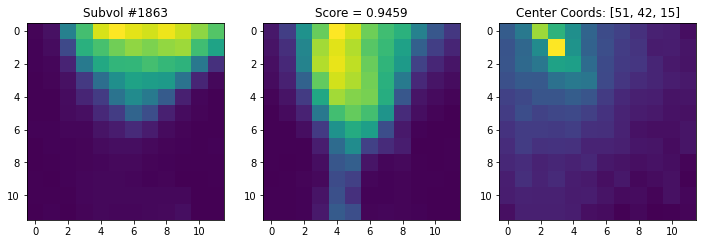

Subvolume #107 in Jaco data:


<Figure size 432x288 with 0 Axes>

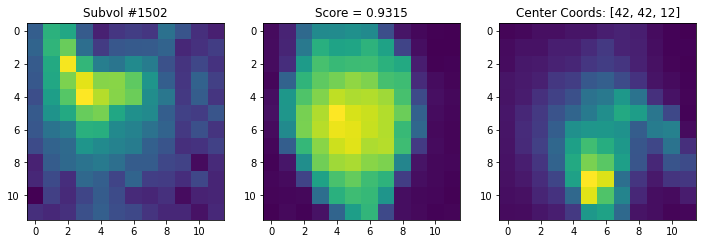

Subvolume #108 in Jaco data:


<Figure size 432x288 with 0 Axes>

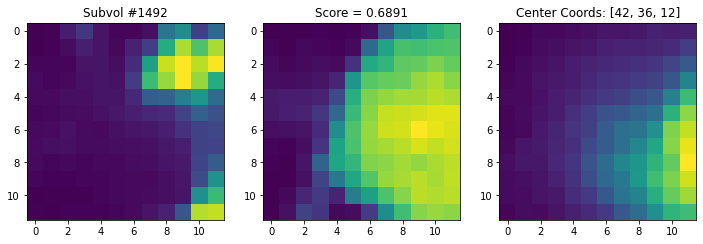

Subvolume #109 in Jaco data:


<Figure size 432x288 with 0 Axes>

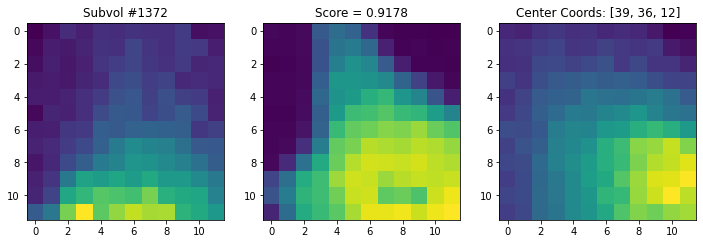

Subvolume #110 in Jaco data:


<Figure size 432x288 with 0 Axes>

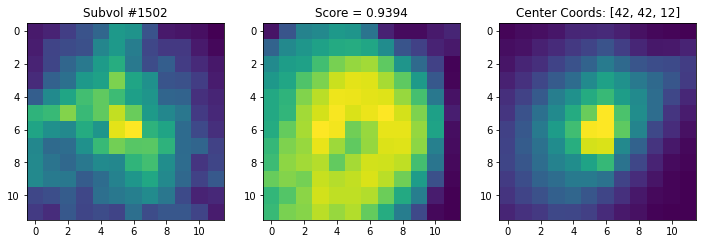

Subvolume #111 in Jaco data:


<Figure size 432x288 with 0 Axes>

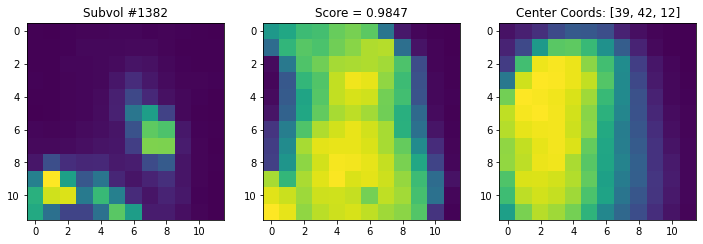

<Figure size 432x288 with 0 Axes>

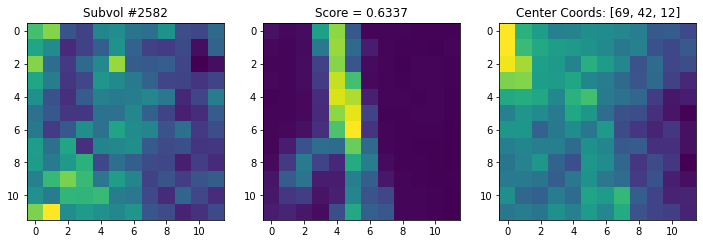

Subvolume #112 in Jaco data:


<Figure size 432x288 with 0 Axes>

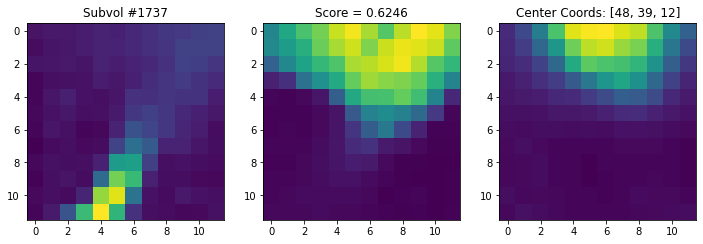

Subvolume #113 in Jaco data:


<Figure size 432x288 with 0 Axes>

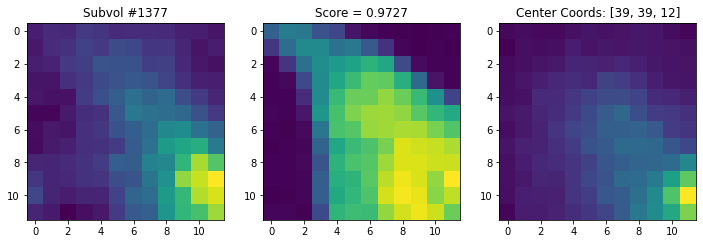

Subvolume #114 in Jaco data:


<Figure size 432x288 with 0 Axes>

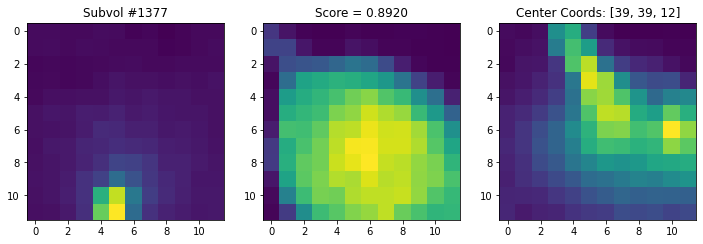

<Figure size 432x288 with 0 Axes>

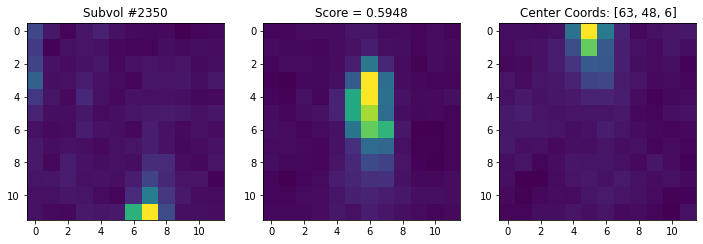

Subvolume #115 in Jaco data:


<Figure size 432x288 with 0 Axes>

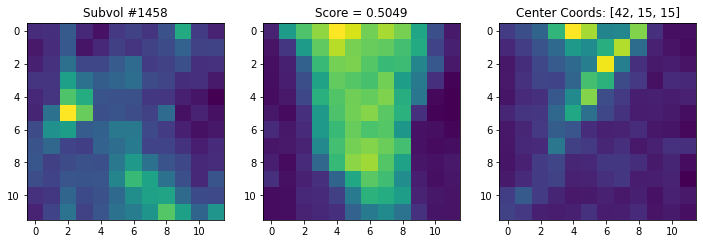

Subvolume #116 in Jaco data:


<Figure size 432x288 with 0 Axes>

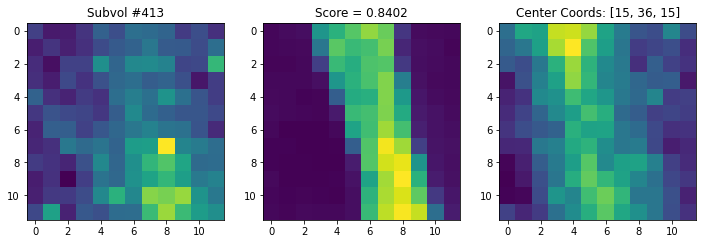

<Figure size 432x288 with 0 Axes>

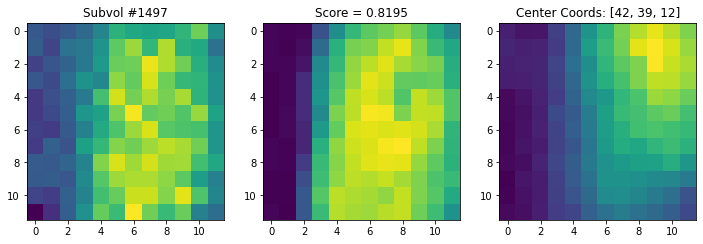

Subvolume #117 in Jaco data:


<Figure size 432x288 with 0 Axes>

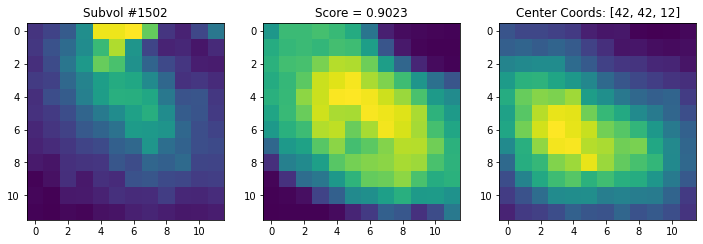

Subvolume #118 in Jaco data:


<Figure size 432x288 with 0 Axes>

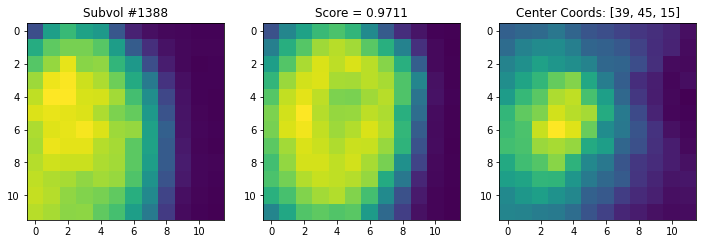

<Figure size 432x288 with 0 Axes>

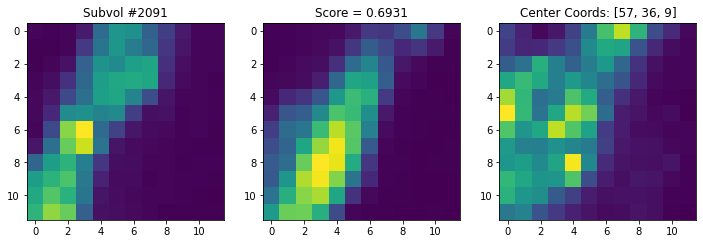

Subvolume #119 in Jaco data:


<Figure size 432x288 with 0 Axes>

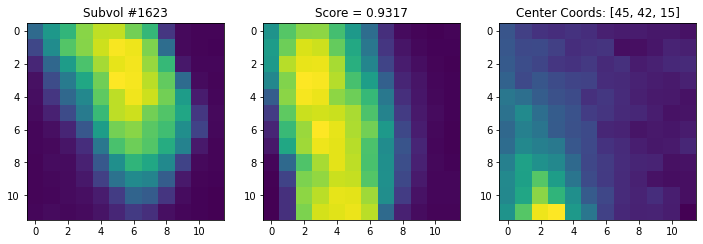

<Figure size 432x288 with 0 Axes>

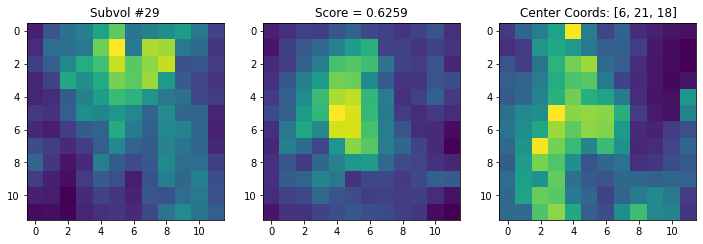

<Figure size 432x288 with 0 Axes>

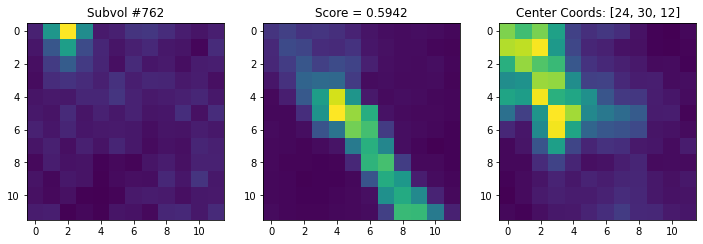

Subvolume #120 in Jaco data:


<Figure size 432x288 with 0 Axes>

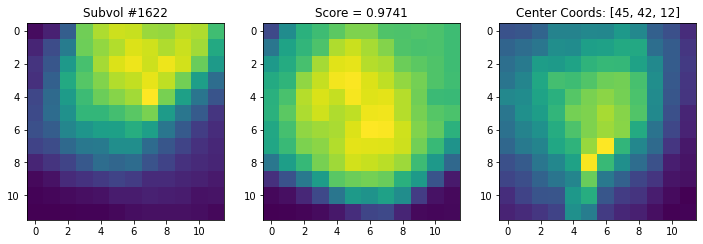

<Figure size 432x288 with 0 Axes>

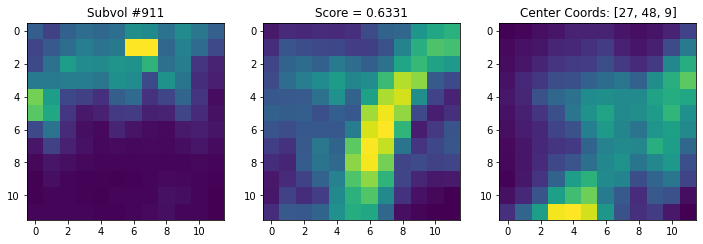

Subvolume #121 in Jaco data:


<Figure size 432x288 with 0 Axes>

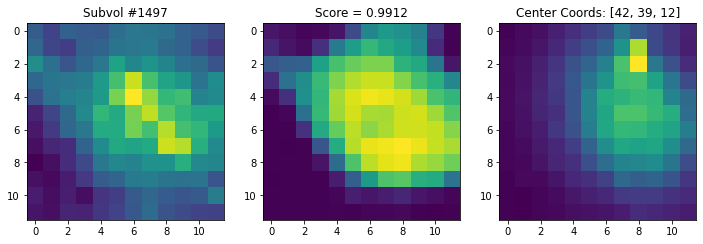

Subvolume #122 in Jaco data:


<Figure size 432x288 with 0 Axes>

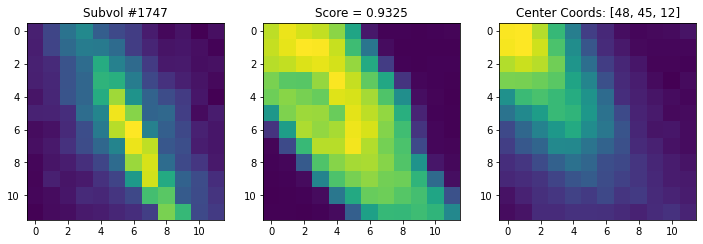

<Figure size 432x288 with 0 Axes>

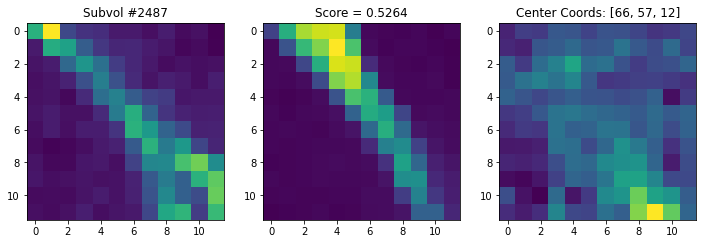

Subvolume #123 in Jaco data:


<Figure size 432x288 with 0 Axes>

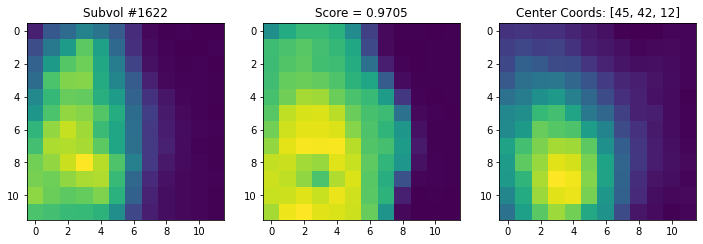

<Figure size 432x288 with 0 Axes>

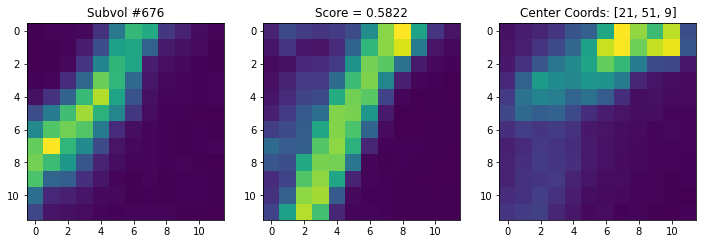

Subvolume #124 in Jaco data:


<Figure size 432x288 with 0 Axes>

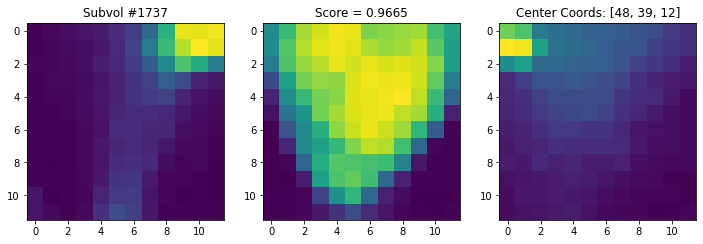

<Figure size 432x288 with 0 Axes>

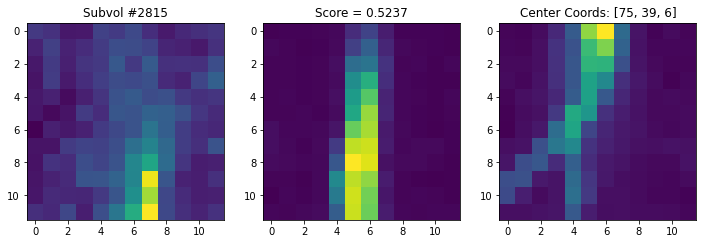

Subvolume #125 in Jaco data:
Subvolume #126 in Jaco data:


<Figure size 432x288 with 0 Axes>

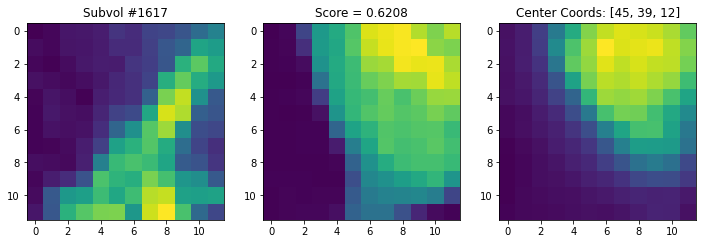

<Figure size 432x288 with 0 Axes>

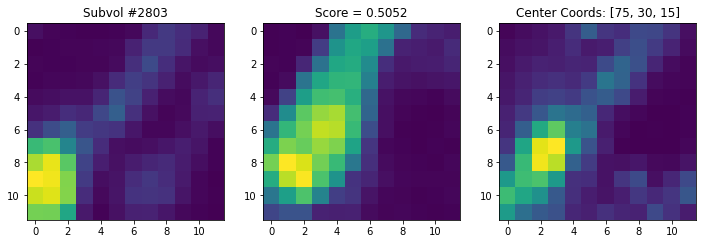

Subvolume #127 in Jaco data:


<Figure size 432x288 with 0 Axes>

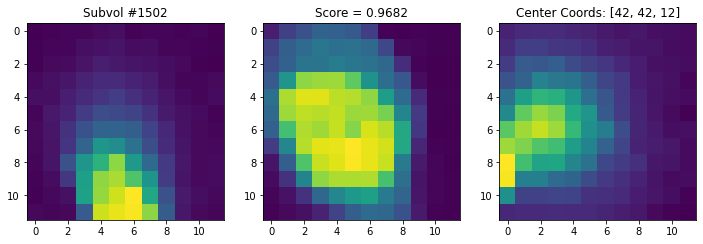

Subvolume #128 in Jaco data:
Subvolume #129 in Jaco data:


<Figure size 432x288 with 0 Axes>

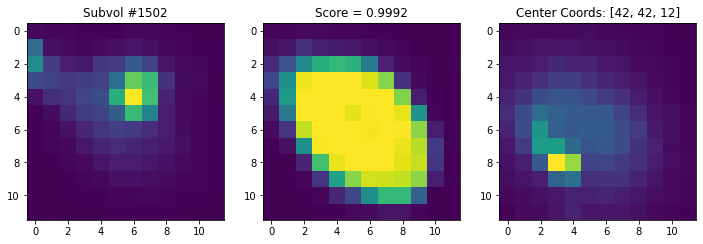

Subvolume #130 in Jaco data:
Subvolume #131 in Jaco data:


<Figure size 432x288 with 0 Axes>

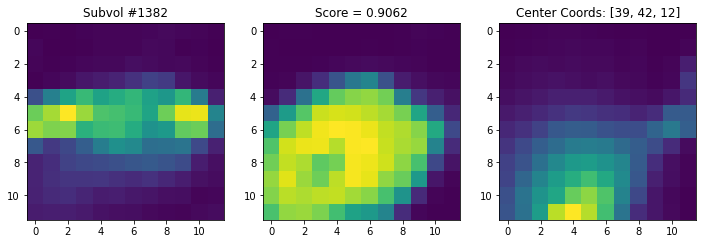

Subvolume #132 in Jaco data:


<Figure size 432x288 with 0 Axes>

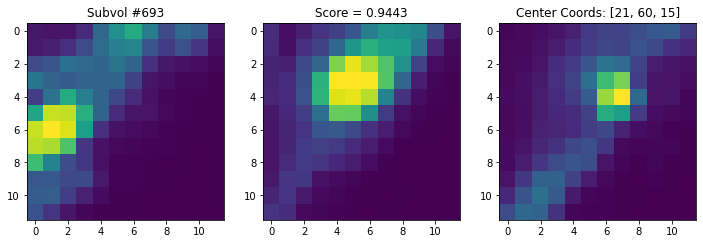

<Figure size 432x288 with 0 Axes>

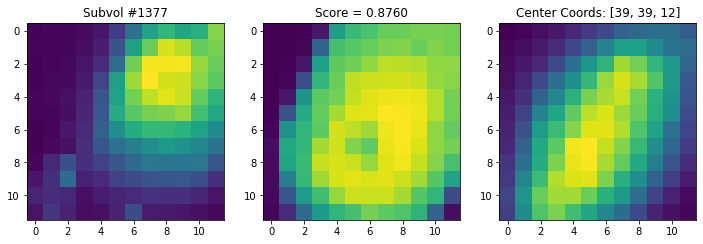

Subvolume #133 in Jaco data:


<Figure size 432x288 with 0 Axes>

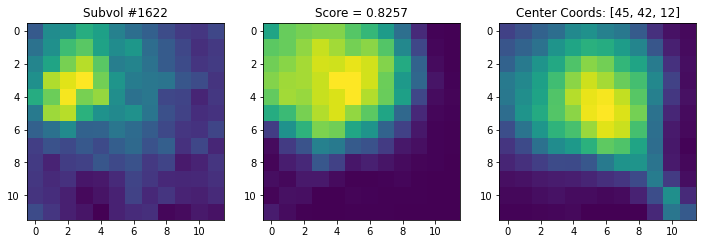

Subvolume #134 in Jaco data:


<Figure size 432x288 with 0 Axes>

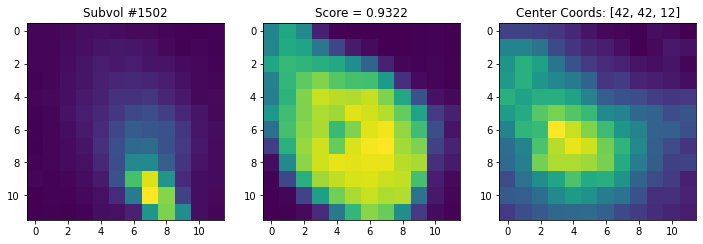

Subvolume #135 in Jaco data:


<Figure size 432x288 with 0 Axes>

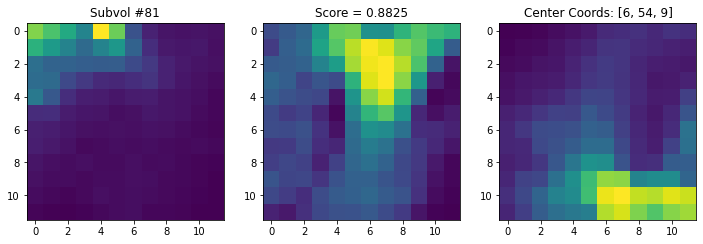

<Figure size 432x288 with 0 Axes>

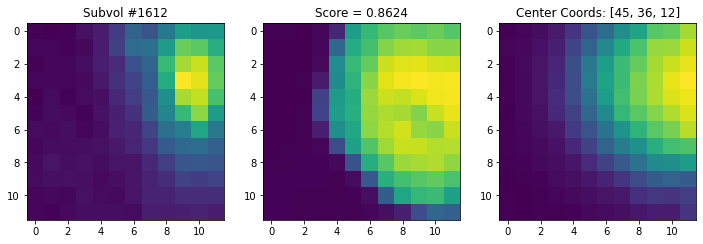

<Figure size 432x288 with 0 Axes>

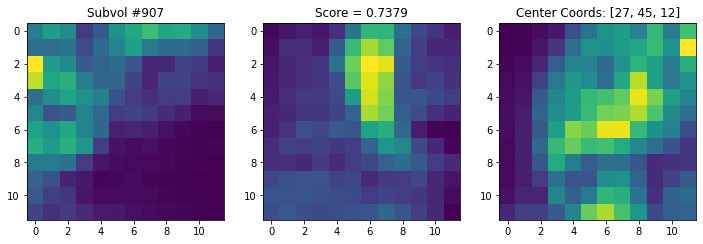

Subvolume #136 in Jaco data:


<Figure size 432x288 with 0 Axes>

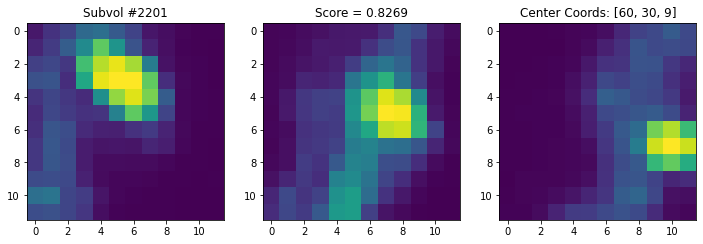

<Figure size 432x288 with 0 Axes>

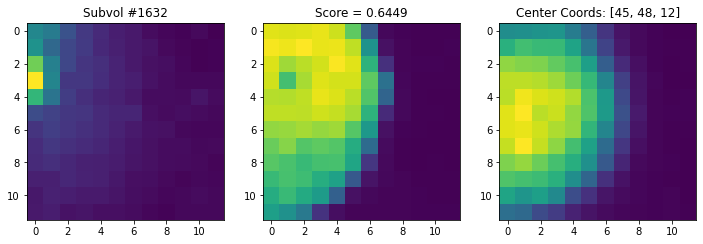

Subvolume #137 in Jaco data:


<Figure size 432x288 with 0 Axes>

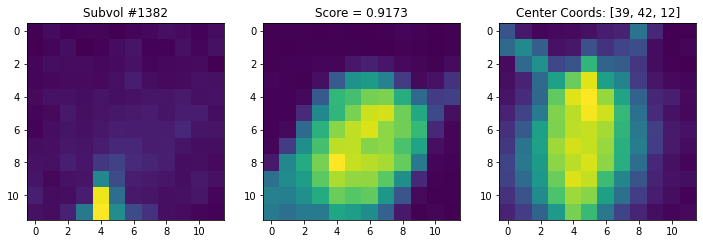

Subvolume #138 in Jaco data:


<Figure size 432x288 with 0 Axes>

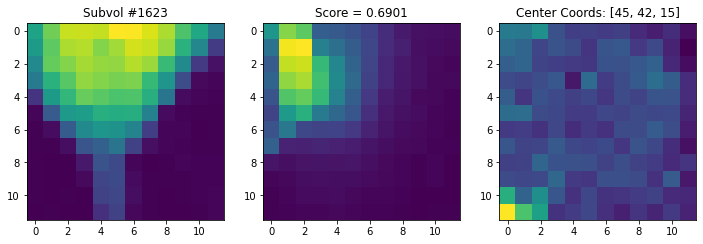

Subvolume #139 in Jaco data:


<Figure size 432x288 with 0 Axes>

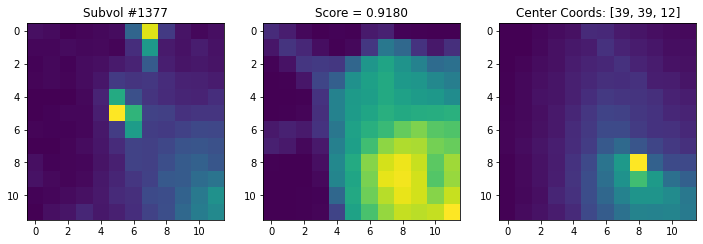

<Figure size 432x288 with 0 Axes>

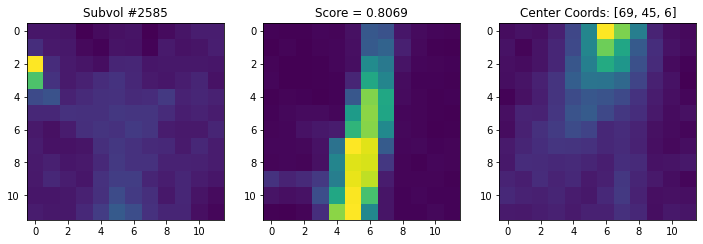

Subvolume #140 in Jaco data:


<Figure size 432x288 with 0 Axes>

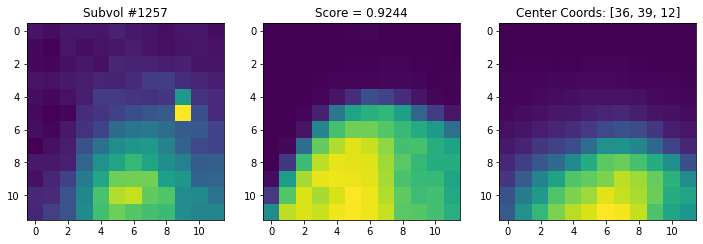

Subvolume #141 in Jaco data:


<Figure size 432x288 with 0 Axes>

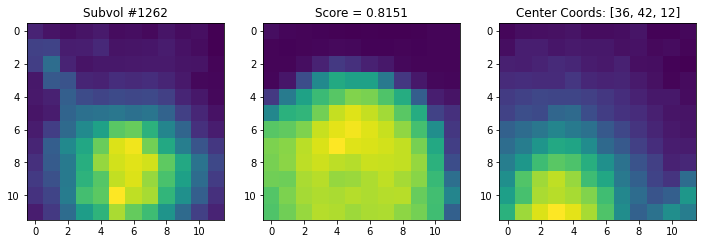

<Figure size 432x288 with 0 Axes>

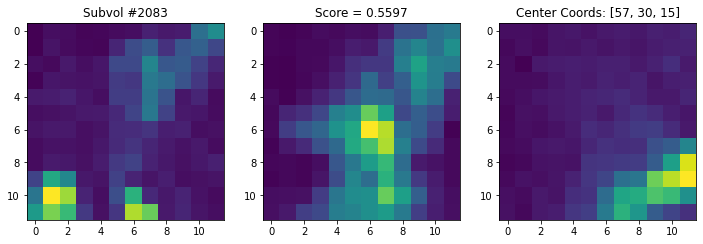

Subvolume #142 in Jaco data:


<Figure size 432x288 with 0 Axes>

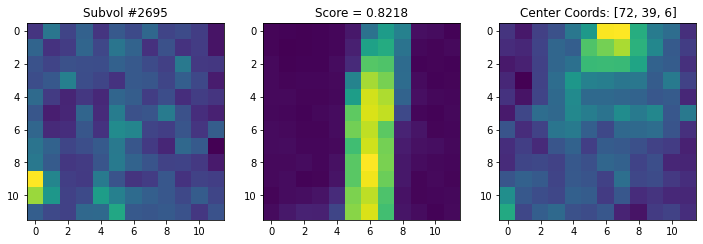

<Figure size 432x288 with 0 Axes>

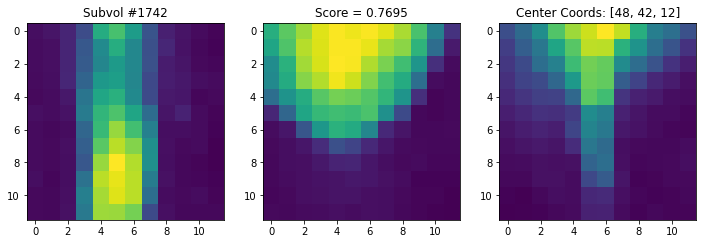

Subvolume #143 in Jaco data:


<Figure size 432x288 with 0 Axes>

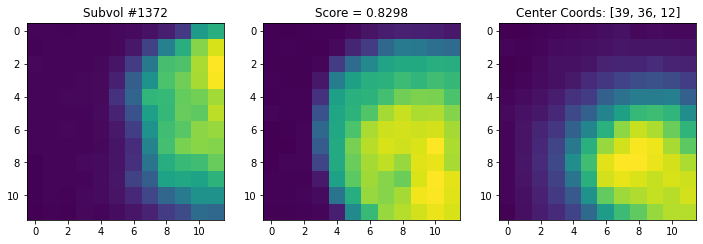

Subvolume #144 in Jaco data:


<Figure size 432x288 with 0 Axes>

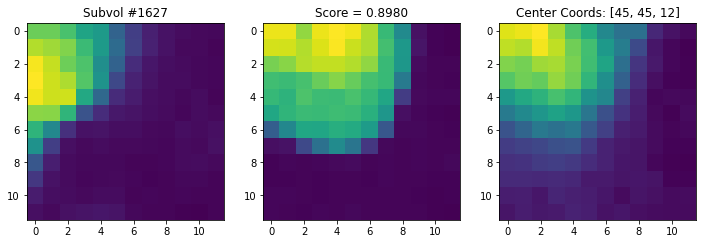

Subvolume #145 in Jaco data:


<Figure size 432x288 with 0 Axes>

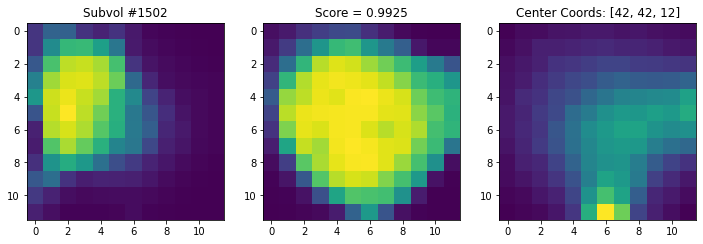

<Figure size 432x288 with 0 Axes>

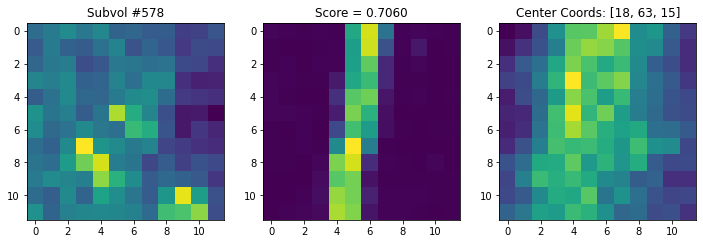

<Figure size 432x288 with 0 Axes>

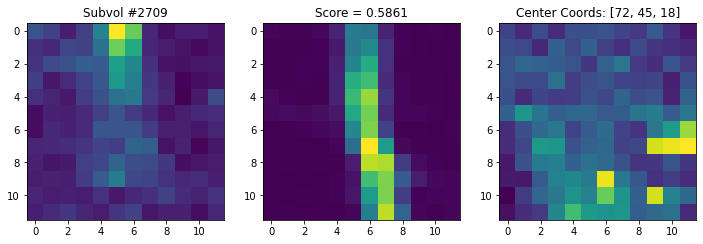

Subvolume #146 in Jaco data:


<Figure size 432x288 with 0 Axes>

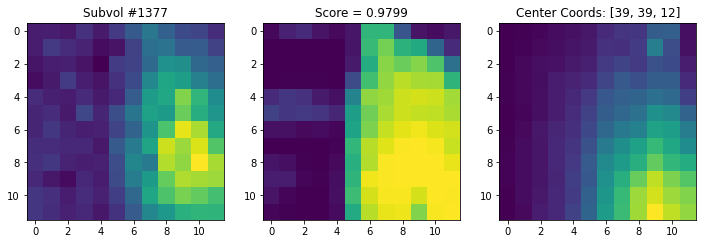

<Figure size 432x288 with 0 Axes>

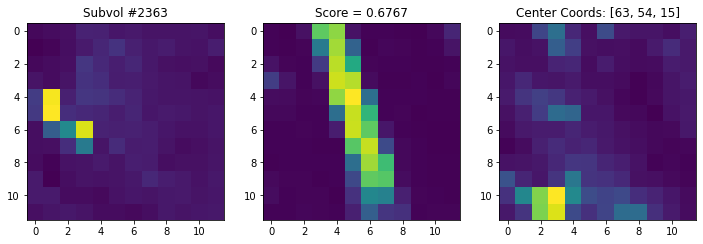

Subvolume #147 in Jaco data:


<Figure size 432x288 with 0 Axes>

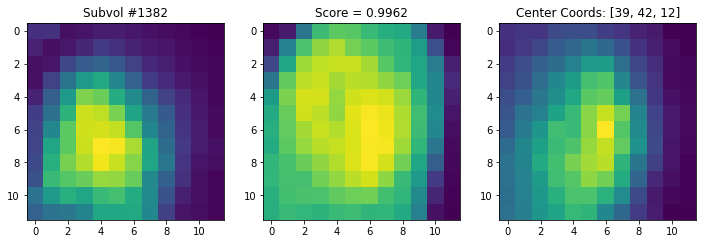

Subvolume #148 in Jaco data:


<Figure size 432x288 with 0 Axes>

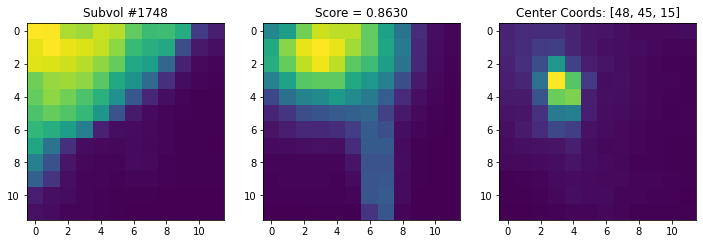

Subvolume #149 in Jaco data:


<Figure size 432x288 with 0 Axes>

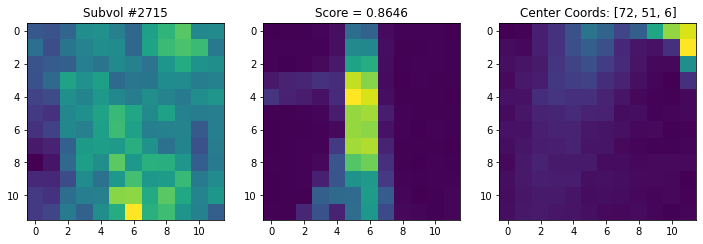

<Figure size 432x288 with 0 Axes>

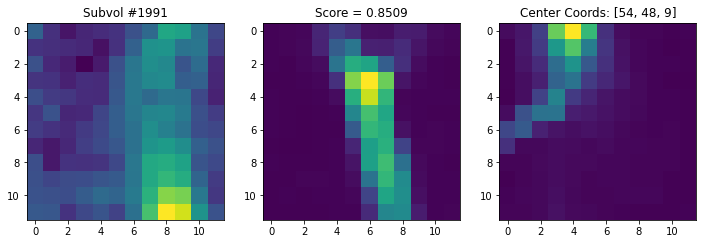

Subvolume #150 in Jaco data:


<Figure size 432x288 with 0 Axes>

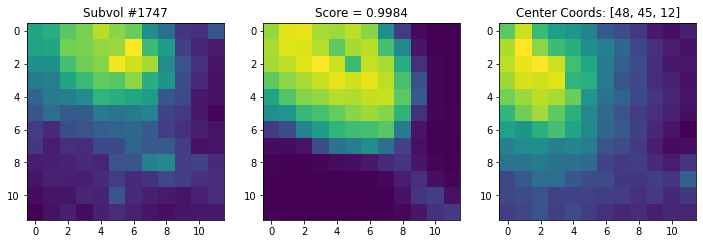

Subvolume #151 in Jaco data:


<Figure size 432x288 with 0 Axes>

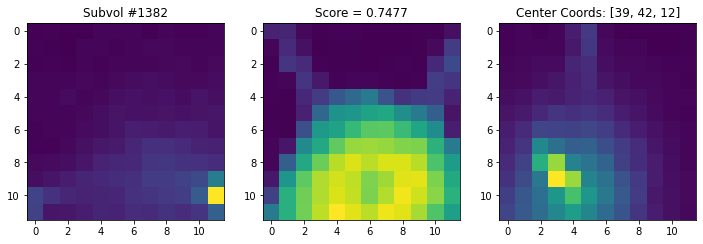

Subvolume #152 in Jaco data:


<Figure size 432x288 with 0 Axes>

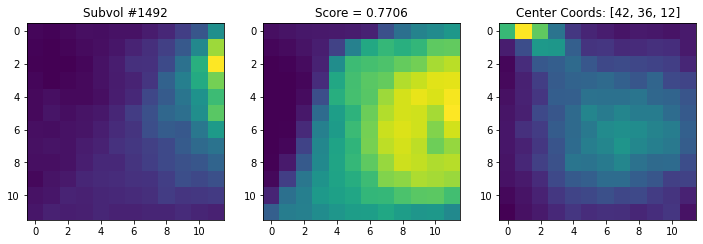

Subvolume #153 in Jaco data:


<Figure size 432x288 with 0 Axes>

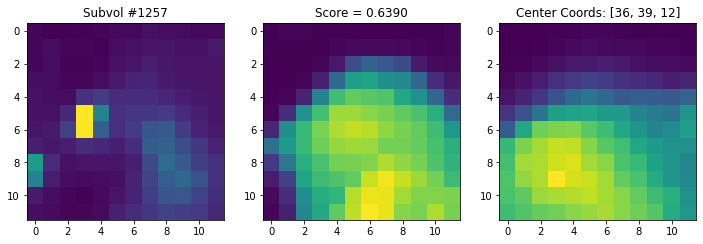

Subvolume #154 in Jaco data:


<Figure size 432x288 with 0 Axes>

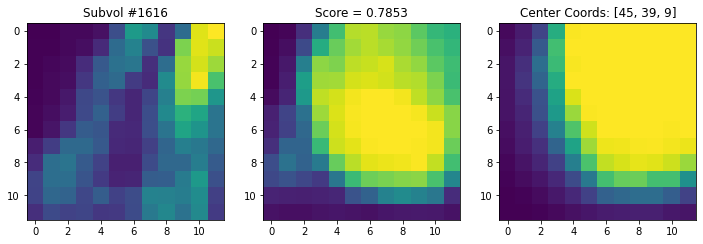

<Figure size 432x288 with 0 Axes>

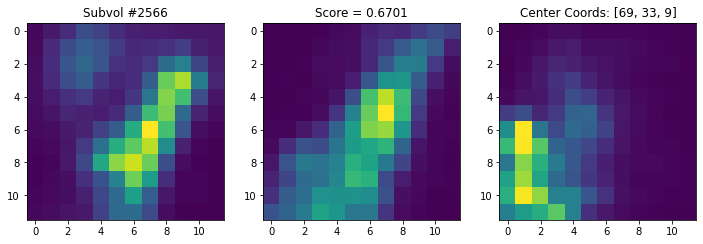

<Figure size 432x288 with 0 Axes>

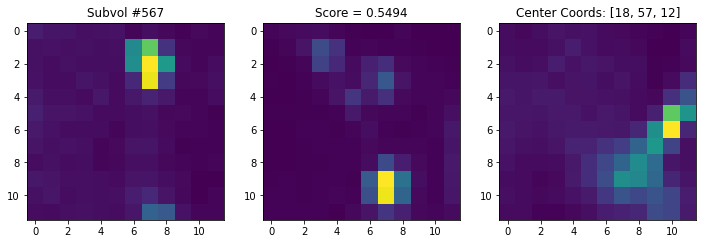

Subvolume #155 in Jaco data:


<Figure size 432x288 with 0 Axes>

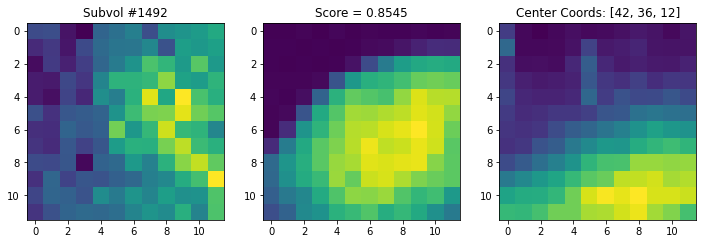

Subvolume #156 in Jaco data:


<Figure size 432x288 with 0 Axes>

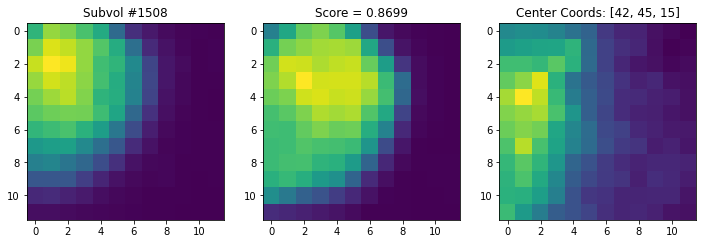

<Figure size 432x288 with 0 Axes>

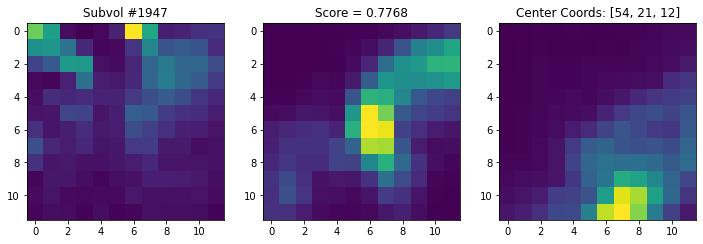

<Figure size 432x288 with 0 Axes>

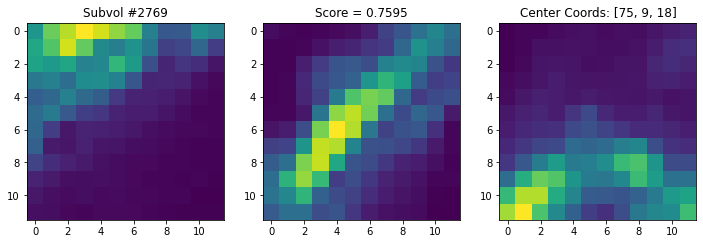

Subvolume #157 in Jaco data:


<Figure size 432x288 with 0 Axes>

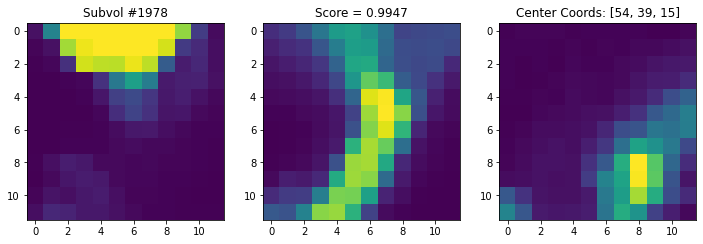

<Figure size 432x288 with 0 Axes>

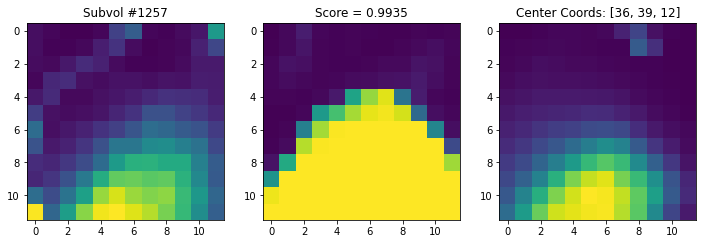

<Figure size 432x288 with 0 Axes>

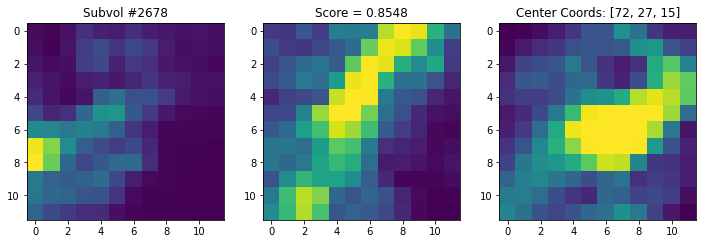

Subvolume #158 in Jaco data:


<Figure size 432x288 with 0 Axes>

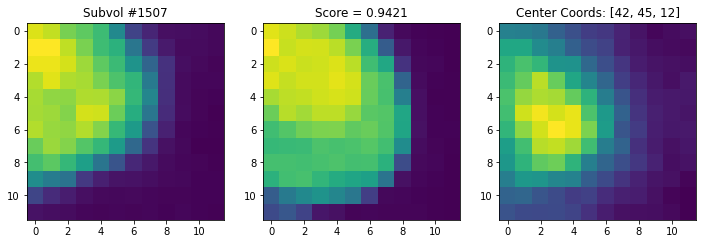

<Figure size 432x288 with 0 Axes>

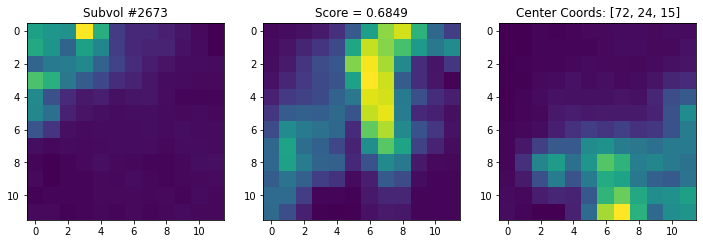

<Figure size 432x288 with 0 Axes>

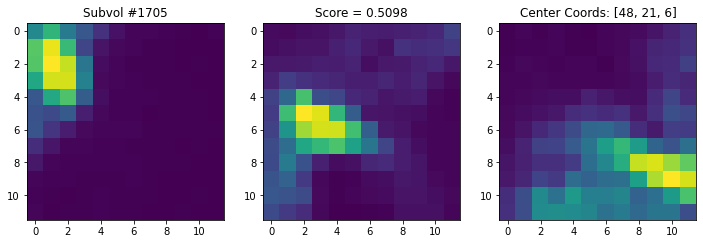

Subvolume #159 in Jaco data:


<Figure size 432x288 with 0 Axes>

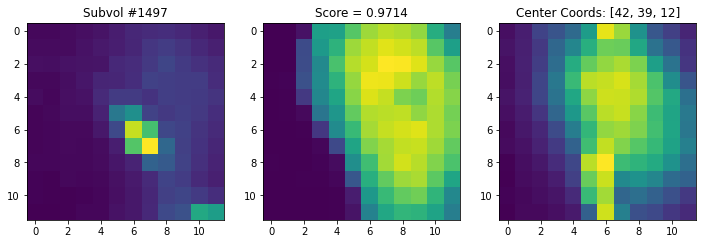

Subvolume #160 in Jaco data:


<Figure size 432x288 with 0 Axes>

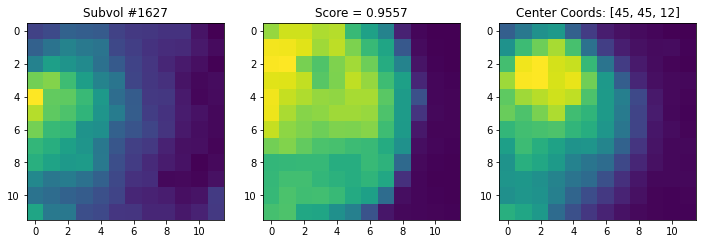

Subvolume #161 in Jaco data:


<Figure size 432x288 with 0 Axes>

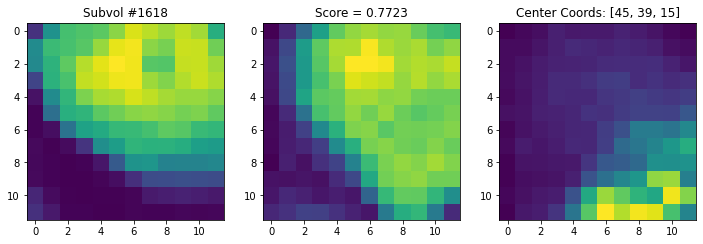

<Figure size 432x288 with 0 Axes>

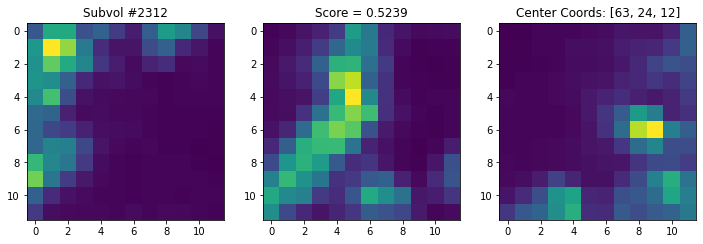

Subvolume #162 in Jaco data:


<Figure size 432x288 with 0 Axes>

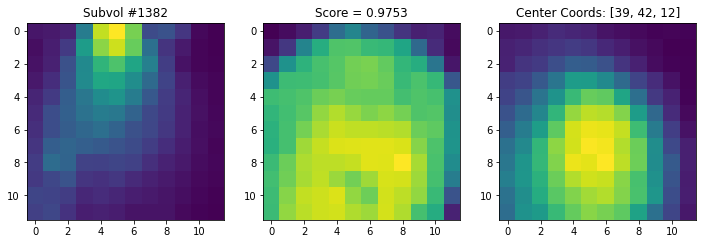

Subvolume #163 in Jaco data:


<Figure size 432x288 with 0 Axes>

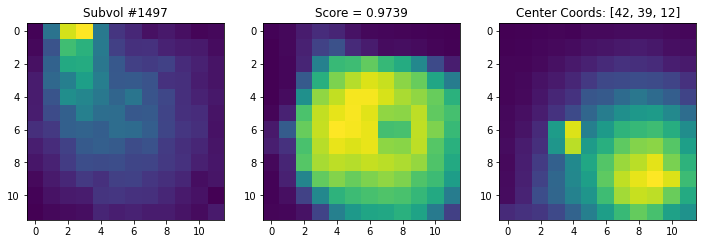

Subvolume #164 in Jaco data:


<Figure size 432x288 with 0 Axes>

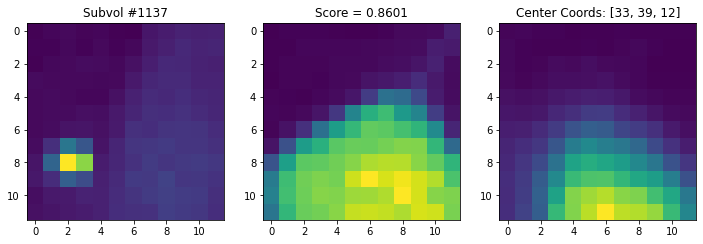

Subvolume #165 in Jaco data:


<Figure size 432x288 with 0 Axes>

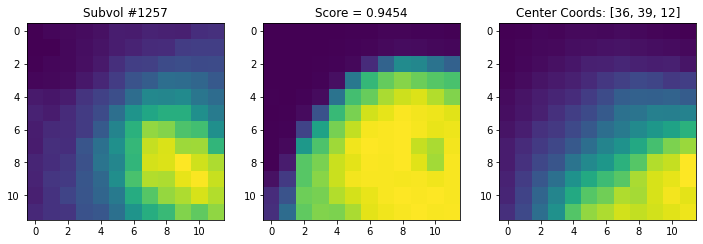

Subvolume #166 in Jaco data:


<Figure size 432x288 with 0 Axes>

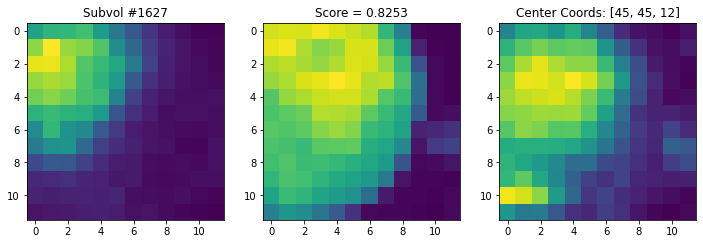

Subvolume #167 in Jaco data:


<Figure size 432x288 with 0 Axes>

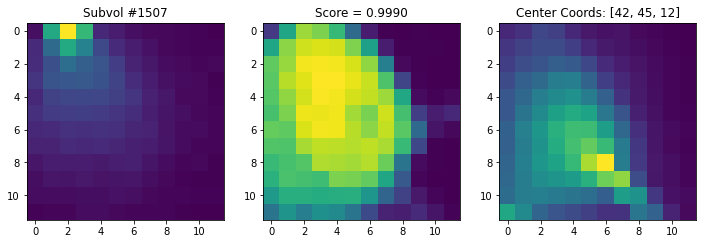

Subvolume #168 in Jaco data:


<Figure size 432x288 with 0 Axes>

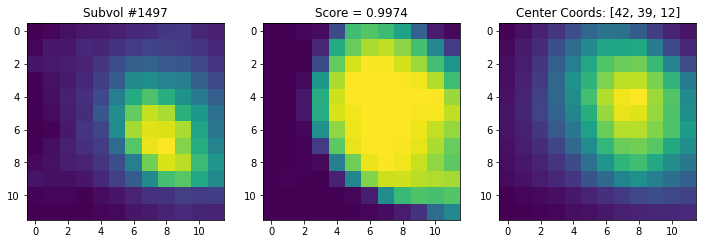

Subvolume #169 in Jaco data:


<Figure size 432x288 with 0 Axes>

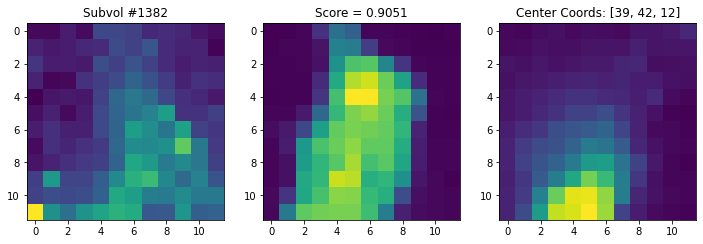

Subvolume #170 in Jaco data:


<Figure size 432x288 with 0 Axes>

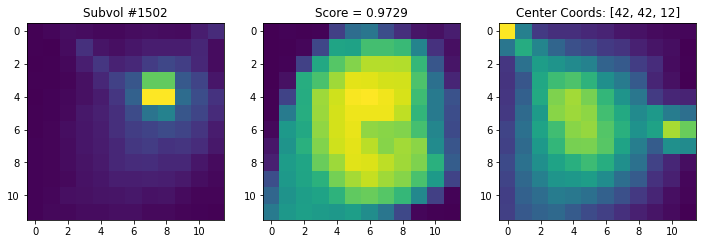

Subvolume #171 in Jaco data:


<Figure size 432x288 with 0 Axes>

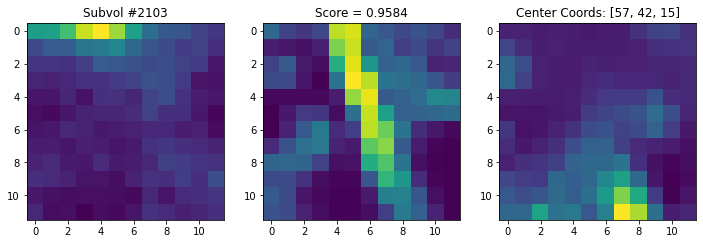

<Figure size 432x288 with 0 Axes>

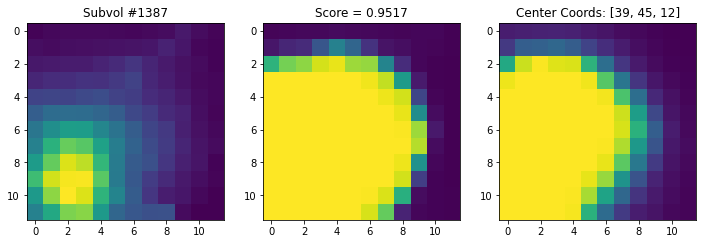

<Figure size 432x288 with 0 Axes>

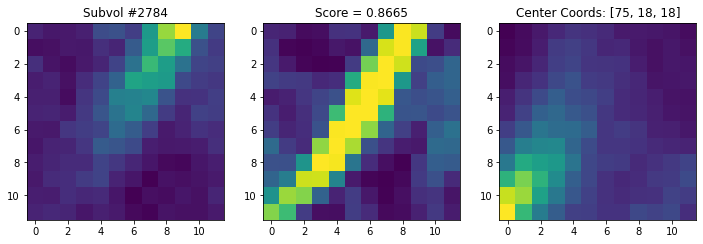

<Figure size 432x288 with 0 Axes>

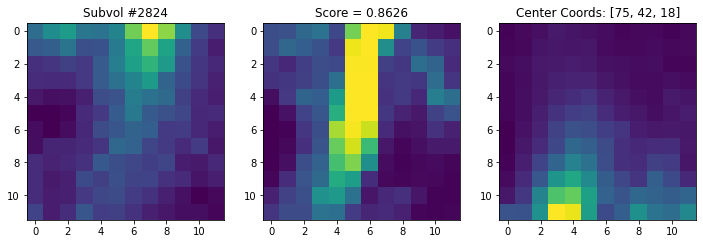

Subvolume #172 in Jaco data:


<Figure size 432x288 with 0 Axes>

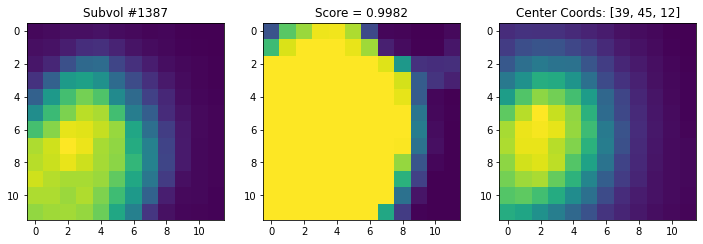

<Figure size 432x288 with 0 Axes>

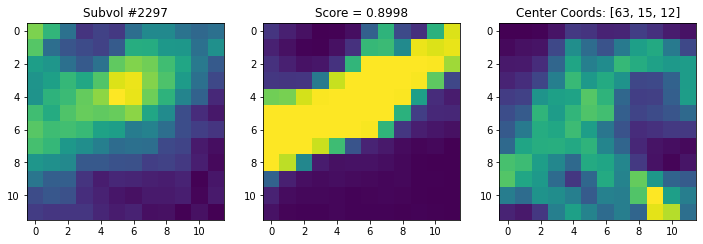

<Figure size 432x288 with 0 Axes>

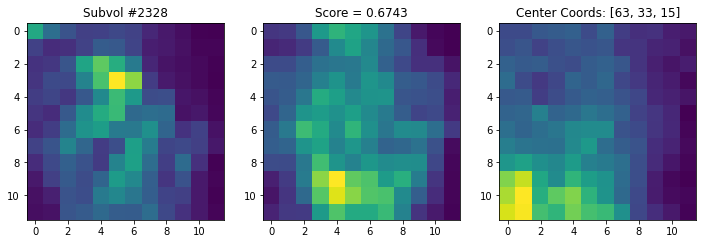

<Figure size 432x288 with 0 Axes>

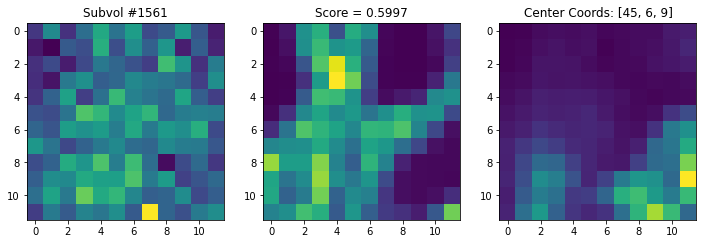

Subvolume #173 in Jaco data:


<Figure size 432x288 with 0 Axes>

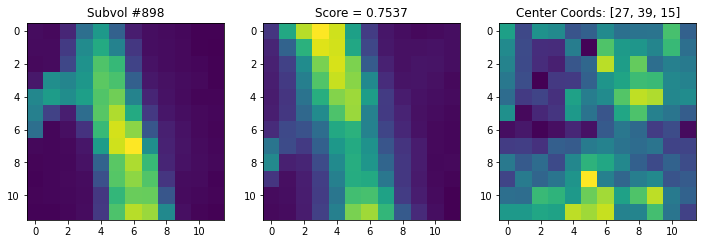

<Figure size 432x288 with 0 Axes>

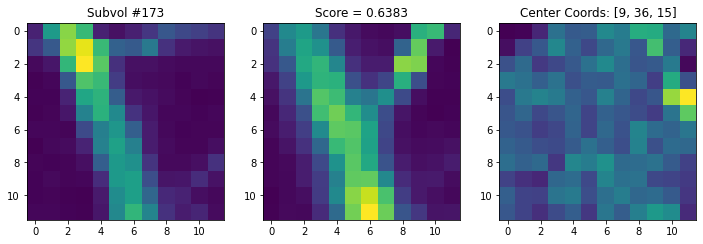

<Figure size 432x288 with 0 Axes>

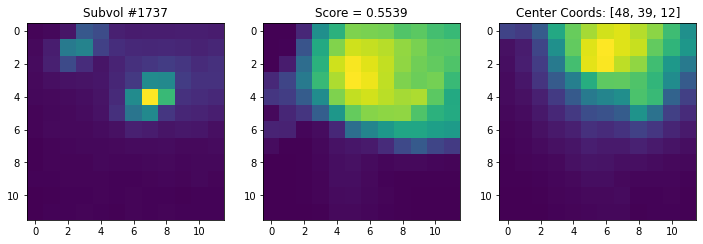

In [16]:
for i, jaco_vol in enumerate(volumes):        
    print("Volume #%d in Jaco data:" % i)
    # Create list 'final' of 12x12x12 subvolumes and associated coords
    final = []; coords = []
    stride = 3; count = 0
    for x in range(0, int(np.ceil((volume.shape[0]-12.0)/stride))):
        for y in range(0, int(np.ceil((volume.shape[1]-12)/stride)) ):
            for z in range(0, int(np.ceil((volume.shape[2]-12)/stride))):
                final.append( jaco_vol[stride*x:stride*x+12, stride*y:stride*y+12, stride*z:stride*z+12] )
                coords.append( [stride*x+6, stride*y+6, stride*z+6] ) 
                count +=1

    # Convert to desired shape            
    final2 = np.zeros((len(final), 12,12,12))
    for ii, subv in enumerate(final):
        final2[ii] = np.asarray(subv)
    final2 = np.squeeze(final2)
#     print("Number of Items in Test Data:", len(final2) )
    final2 = np.expand_dims(final2, axis=1)
#     print("Shape of Test Data Vector:", final2.shape)
#     print("There are " + str(count) + " subvolumes.")
    
    # Normalize
    MAX = np.amax(final2)
    final_norm = final2/MAX
    
    # Run all potential windows through model
    labels_norm=[]
    for ii in range(len(labels_norm), len(final_norm)):
        w = torch.from_numpy(final_norm[ii])
        w = w.unsqueeze(1)
        w = w.double()
        w = m1(w)
        labels_norm.append(w.detach().numpy())
    labels_norm = np.asarray(labels_norm)
    labels_norm = labels_norm.squeeze()
#     print(len(labels_norm))
    
    # Order the list by score
    arr = [[float(test), ii, final_norm[ii].squeeze()] for ii, test in enumerate(labels_norm)] 
    arr.sort(reverse=True)
    onlyScores = [item[0] for item in arr[:20]]

    # Display the subvols in order of score
    begin = 0
    end = 20
    skip = []
    dist = 15
    for ii, subvol in enumerate(arr[begin:end]): 
#         print('')
#         print('ii = '+ str(ii))
        if subvol[0]<=.5:
            break
        else:
            threeCoords = coords[subvol[1]] 
#             suffix = "th" if 4<=ii+1%100<=20 else {1:"st",2:"nd",3:"rd"}.get(ii+1%10, "th")
#             print("Using the " + str(ii) + suffix +" highest-scoring subvolume (coodinates=" + str(threeCoords) +')...')
            if ii in skip:
#                 print("continue because we already removed this duplicate subvolume from arr.\n")
                continue
            else:
                fig = plt.figure()
                f, axarr = plt.subplots(1,3, figsize=(12,12) )  
                axarr[0].imshow(subvol[2][:,:,3] )
                axarr[1].imshow(subvol[2][:,:,6] )
                axarr[2].imshow(subvol[2][:,:,9] )
                axarr[0].set_title('Subvol #%d'        % subvol[1] ) 
                axarr[1].set_title('Score = %.4f'      % subvol[0] ) 
                axarr[2].set_title('Center Coords: %s' % coords[subvol[1]] ) 
                plt.show()

#                 print("filter out the other high-scoring subvolumes that are too close: ")
                for jj, subvol2 in enumerate(arr[begin+ii+1 : end]): 
                    jj = begin+ii+1+jj                    
                    threeCoords2 = coords[subvol2[1]]           
#                     print('jj = %d' % jj)
#                     print('skip = %s' % skip)
                    if jj in skip:
#                         print("continue because we already removed this duplicate subvolume from arr (using jj).\n")
                        continue
                    
                    elif   abs(threeCoords[0]-threeCoords2[0]) > dist \
                        or abs(threeCoords[1]-threeCoords2[1]) > dist \
                        or abs(threeCoords[2]-threeCoords2[2]) > dist:
#                         print(threeCoords)
#                         print(threeCoords2)
#                         print('  jj=' + str(jj) + ' coords are far away... coords = ' + str(threeCoords2) )
#                         print('')
                        continue
                    else:
#                         print('  jj=' + str(jj) + " removing " + str(threeCoords2) )
#                         print(' ')
#                         arr.remove( arr[jj] ) % Do not use this
                        skip.append(jj)
#                 print(' ')

## Print the output of results

In [17]:
print('Stride size = %s' % stride)
# Multi-cells
print( '%d / 174 detected multiple cells' % len([2, 3, 14, 23, 24, 25, 27, 35, 36, 38, 39, 41, 43, 45, 48, 55, 56, 57,\
                                                 58, 59, 60, 61, 74, 75, 77, 81, 88, 89, 94, 96, 99, 104, 111, 114, \
                                                 116, 118, 119, 120, 122, 123, 124, 126, 132, 135, 136, 139, 140, 141,\
                                                 142, 145, 146, 149,  154, 156, 157, 158, 161, 171, 172, 173]))
# Not Detected
no_cells = int(len([4, 9, 16, 18, 20, 22, 62, 67, 68, 72, 82, 85, 102, 103, 105, 125, 128, 130]))
print( '%d / 174 cells detected' % (174-no_cells)) 
print("Accuracy = %.2f" % ((174-no_cells)/174) )

Stride size = 3
60 / 174 detected multiple cells
156 / 174 cells detected
Accuracy = 0.90
